In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

- `customerID`: Customer ID
- `gender`: Whether the customer is a male or a female
- `SeniorCitizen`: Whether the customer is a senior citizen or not (1, 0)
- `Partner`: Whether the customer has a partner or not (Yes, No)
- `Dependents`: Whether the customer has dependents or not (Yes, No)
- `tenure`: Number of months the customer has stayed with the company
- `PhoneService`: Whether the customer has a phone service or not (Yes, No)
- `MultipleLines`: Whether the customer has multiple lines or not (Yes, No, No phone service)
- `InternetService`: Customer’s internet service provider (DSL, Fiber optic, No)
- `OnlineSecurity`: Whether the customer has online security or not (Yes, No, No internet service)
- `OnlineBackup`: Whether the customer has online backup or not (Yes, No, No internet service)
- `DeviceProtection`: Whether the customer has device protection or not (Yes, No, No internet service)
- `TechSupport`: Whether the customer has tech support or not (Yes, No, No internet service)
- `StreamingTV`: Whether the customer has streaming TV or not (Yes, No, No internet service)
- `StreamingMovies`: Whether the customer has streaming movies or not (Yes, No, No internet service)
- `Contract`: The contract term of the customer (Month-to-month, One year, Two year)
- `PaperlessBilling`: Whether the customer has paperless billing or not (Yes, No)
- `PaymentMethod`: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- `MonthlyCharges`: The amount charged to the customer monthly
- `TotalCharges`: The total amount charged to the customer
- `Churn`: Whether the customer churned or not (Yes or No)

In [2]:
df = pd.read_csv("/Users/adamrivardwalter/Data for Processing/Preprocessing/Classification/Customer Churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
pd.set_option('display.max_columns', None)
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


From above, we can see that only `SeniorCitizen`, `tenure`, and `MonthlyCharges` are going to produce a proper statistical analysis via .describe(), so we need to change them into either `int` or `float`

In [4]:
def replace_values(df):
    # Mapping dictionaries for replacement
    contract_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
    payment_mapping = {
        'Bank transfer (automatic)': 0, 
        'Credit card (automatic)': 1, 
        'Electronic check': 2, 
        'Mailed check': 3
    }
    internet_mapping = {'DSL': 1, 'Fiber optic': 2, 'No internet service': 0}
    phone_mapping = {'No phone service': 0, 'Yes': 1, 'No': 0}
    
    # Replace values for each relevant column
    df['Contract'] = df['Contract'].map(contract_mapping)
    df['PaymentMethod'] = df['PaymentMethod'].map(payment_mapping)
    df['InternetService'] = df['InternetService'].map(internet_mapping)
    df['PhoneService'] = df['PhoneService'].replace(phone_mapping)
    
    # General Yes/No to binary for all columns where applicable
    yes_no_mapping = {'Yes': 1, 'No': 0}
    df.replace(yes_no_mapping, inplace=True)
    
    # Gender mapping (specific to binary case)
    gender_mapping = {'Female': 0, 'Male': 1}
    df['gender'] = df['gender'].map(gender_mapping)
    
    return df

In [5]:
df2 = replace_values(df)

In [6]:
def convert_columns_to_numeric(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = ['customerID']  # Default columns to exclude from conversion
    
    for col in df.columns:
        if col in exclude_cols:
            continue  # Skip columns that are in the exclude list

        # Convert to numeric, with coercion for any non-numeric values
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Check if the column is float type and can be converted to an integer type
        if pd.api.types.is_float_dtype(df[col]):
            # If all values are integers (or NaNs), convert to integer type
            if df[col].dropna().apply(lambda x: x.is_integer()).all():
                df[col] = df[col].astype('Int64')  # Nullable integer to support NaNs
            else:
                df[col] = df[col].astype(float)  # Keep as float if non-integer values are present
        elif pd.api.types.is_integer_dtype(df[col]):
            df[col] = df[col].astype('Int64')  # Convert integer columns to nullable integer type

    return df

In [7]:
df2 = convert_columns_to_numeric(df2)

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   Int64  
 2   SeniorCitizen     7043 non-null   Int64  
 3   Partner           7043 non-null   Int64  
 4   Dependents        7043 non-null   Int64  
 5   tenure            7043 non-null   Int64  
 6   PhoneService      7043 non-null   Int64  
 7   MultipleLines     6361 non-null   Int64  
 8   InternetService   5517 non-null   Int64  
 9   OnlineSecurity    5517 non-null   Int64  
 10  OnlineBackup      5517 non-null   Int64  
 11  DeviceProtection  5517 non-null   Int64  
 12  TechSupport       5517 non-null   Int64  
 13  StreamingTV       5517 non-null   Int64  
 14  StreamingMovies   5517 non-null   Int64  
 15  Contract          7043 non-null   Int64  
 16  PaperlessBilling  7043 non-null   Int64  


In [9]:
df2.describe().T

count         mean          std    min     25%       50%  \
gender            7043.0     0.504756     0.500013    0.0     0.0       1.0   
SeniorCitizen     7043.0     0.162147     0.368612    0.0     0.0       0.0   
Partner           7043.0     0.483033     0.499748    0.0     0.0       0.0   
Dependents        7043.0     0.299588      0.45811    0.0     0.0       0.0   
tenure            7043.0    32.371149    24.559481    0.0     9.0      29.0   
PhoneService      7043.0     0.903166     0.295752    0.0     1.0       1.0   
MultipleLines     6361.0     0.467065     0.498953    0.0     0.0       0.0   
InternetService   5517.0     1.561175     0.496289    1.0     1.0       2.0   
OnlineSecurity    5517.0      0.36596     0.481742    0.0     0.0       0.0   
OnlineBackup      5517.0     0.440276     0.496465    0.0     0.0       0.0   
DeviceProtection  5517.0     0.439007     0.496311    0.0     0.0       0.0   
TechSupport       5517.0     0.370491      0.48298    0.0     0.0       0.0   
StreamingTV       5517.0     0.490665     0.499958    0.0     0.0       0.0   
StreamingMovies   5517.0     0.495197     0.500022    0.0     0.0       0.0   
Contract          7043.0     0.690473     0.833755    0.0     0.0       0.0   
PaperlessBilling  7043.0     0.592219     0.491457    0.0     0.0       1.0   
PaymentMethod     7043.0     1.574329     1.068104    0.0     1.0       2.0   
MonthlyCharges    7043.0    64.761692    30.090047  18.25    35.5     70.35   
TotalCharges      7032.0  2283.300441  2266.771362   18.8  401.45  1397.475   
Churn             7043.0      0.26537     0.441561    0.0     0.0       0.0   

                        75%     max  
gender                  1.0     1.0  
SeniorCitizen           0.0     1.0  
Partner                 1.0     1.0  
Dependents              1.0     1.0  
tenure                 55.0    72.0  
PhoneService            1.0     1.0  
MultipleLines           1.0     1.0  
InternetService         2.0     2.0  
OnlineSecurity          1.0     1.0  
OnlineBackup            1.0     1.0  
DeviceProtection        1.0     1.0  
TechSupport             1.0     1.0  
StreamingTV             1.0     1.0  
StreamingMovies         1.0     1.0  
Contract                1.0     2.0  
PaperlessBilling        1.0     1.0  
PaymentMethod           2.0     3.0  
MonthlyCharges        89.85  118.75  
TotalCharges      3794.7375  8684.8  
Churn                   1.0     1.0

In [10]:
churn = df2[df2['Churn'] == 1].describe().T
not_churn = df2[df2['Churn'] == 0].describe().T

In [11]:
churn

count         mean          std    min    25%     50%  \
gender            1869.0     0.497592     0.500128    0.0    0.0     0.0   
SeniorCitizen     1869.0     0.254682     0.435799    0.0    0.0     0.0   
Partner           1869.0     0.357945     0.479524    0.0    0.0     0.0   
Dependents        1869.0     0.174425     0.379576    0.0    0.0     0.0   
tenure            1869.0    17.979133    19.531123    1.0    2.0    10.0   
PhoneService      1869.0     0.909042     0.287626    0.0    1.0     1.0   
MultipleLines     1699.0     0.500294     0.500147    0.0    0.0     1.0   
InternetService   1756.0      1.73861     0.439517    1.0    1.0     2.0   
OnlineSecurity    1756.0     0.167995     0.373969    0.0    0.0     0.0   
OnlineBackup      1756.0     0.297836     0.457437    0.0    0.0     0.0   
DeviceProtection  1756.0     0.310364     0.462775    0.0    0.0     0.0   
TechSupport       1756.0     0.176538     0.381385    0.0    0.0     0.0   
StreamingTV       1756.0     0.463554     0.498812    0.0    0.0     0.0   
StreamingMovies   1756.0     0.465831     0.498973    0.0    0.0     0.0   
Contract          1869.0     0.140182     0.414714    0.0    0.0     0.0   
PaperlessBilling  1869.0     0.749064     0.433668    0.0    0.0     1.0   
PaymentMethod     1869.0      1.76458     0.886617    0.0    1.0     2.0   
MonthlyCharges    1869.0    74.441332    24.666053  18.85  56.15   79.65   
TotalCharges      1869.0  1531.796094  1890.822994  18.85  134.5  703.55   
Churn             1869.0          1.0          0.0    1.0    1.0     1.0   

                     75%     max  
gender               1.0     1.0  
SeniorCitizen        1.0     1.0  
Partner              1.0     1.0  
Dependents           0.0     1.0  
tenure              29.0    72.0  
PhoneService         1.0     1.0  
MultipleLines        1.0     1.0  
InternetService      2.0     2.0  
OnlineSecurity       0.0     1.0  
OnlineBackup         1.0     1.0  
DeviceProtection     1.0     1.0  
TechSupport          0.0     1.0  
StreamingTV          1.0     1.0  
StreamingMovies      1.0     1.0  
Contract             0.0     2.0  
PaperlessBilling     1.0     1.0  
PaymentMethod        2.0     3.0  
MonthlyCharges      94.2  118.35  
TotalCharges      2331.3  8684.8  
Churn                1.0     1.0

In [12]:
not_churn

count         mean          std    min      25%     50%  \
gender            5174.0     0.507344     0.499994    0.0      0.0     1.0   
SeniorCitizen     5174.0     0.128721     0.334923    0.0      0.0     0.0   
Partner           5174.0     0.528218     0.499251    0.0      0.0     1.0   
Dependents        5174.0     0.344801     0.475349    0.0      0.0     0.0   
tenure            5174.0    37.569965    24.113777    0.0     15.0    38.0   
PhoneService      5174.0     0.901044     0.298632    0.0      1.0     1.0   
MultipleLines     4662.0     0.454955      0.49802    0.0      0.0     0.0   
InternetService   3761.0      1.47833     0.499597    1.0      1.0     1.0   
OnlineSecurity    3761.0     0.458389     0.498332    0.0      0.0     0.0   
OnlineBackup      3761.0      0.50678     0.500021    0.0      0.0     1.0   
DeviceProtection  3761.0     0.499069     0.500066    0.0      0.0     0.0   
TechSupport       3761.0     0.461048     0.498547    0.0      0.0     0.0   
StreamingTV       3761.0     0.503324     0.500055    0.0      0.0     1.0   
StreamingMovies   3761.0     0.508907     0.499987    0.0      0.0     1.0   
Contract          5174.0     0.889254     0.857478    0.0      0.0     1.0   
PaperlessBilling  5174.0     0.535562     0.498782    0.0      0.0     1.0   
PaymentMethod     5174.0     1.505605     1.118647    0.0      1.0     2.0   
MonthlyCharges    5174.0    61.265124    31.092648  18.25     25.1  64.425   
TotalCharges      5163.0  2555.344141  2329.456984   18.8  577.825  1683.6   
Churn             5174.0          0.0          0.0    0.0      0.0     0.0   

                       75%      max  
gender                 1.0      1.0  
SeniorCitizen          0.0      1.0  
Partner                1.0      1.0  
Dependents             1.0      1.0  
tenure                61.0     72.0  
PhoneService           1.0      1.0  
MultipleLines          1.0      1.0  
InternetService        2.0      2.0  
OnlineSecurity         1.0      1.0  
OnlineBackup           1.0      1.0  
DeviceProtection       1.0      1.0  
TechSupport            1.0      1.0  
StreamingTV            1.0      1.0  
StreamingMovies        1.0      1.0  
Contract               2.0      2.0  
PaperlessBilling       1.0      1.0  
PaymentMethod          3.0      3.0  
MonthlyCharges        88.4   118.75  
TotalCharges      4264.125  8672.45  
Churn                  0.0      0.0

In [13]:
churn['mean'] = pd.to_numeric(churn['mean'], errors='coerce')
not_churn['mean'] = pd.to_numeric(not_churn['mean'], errors='coerce')

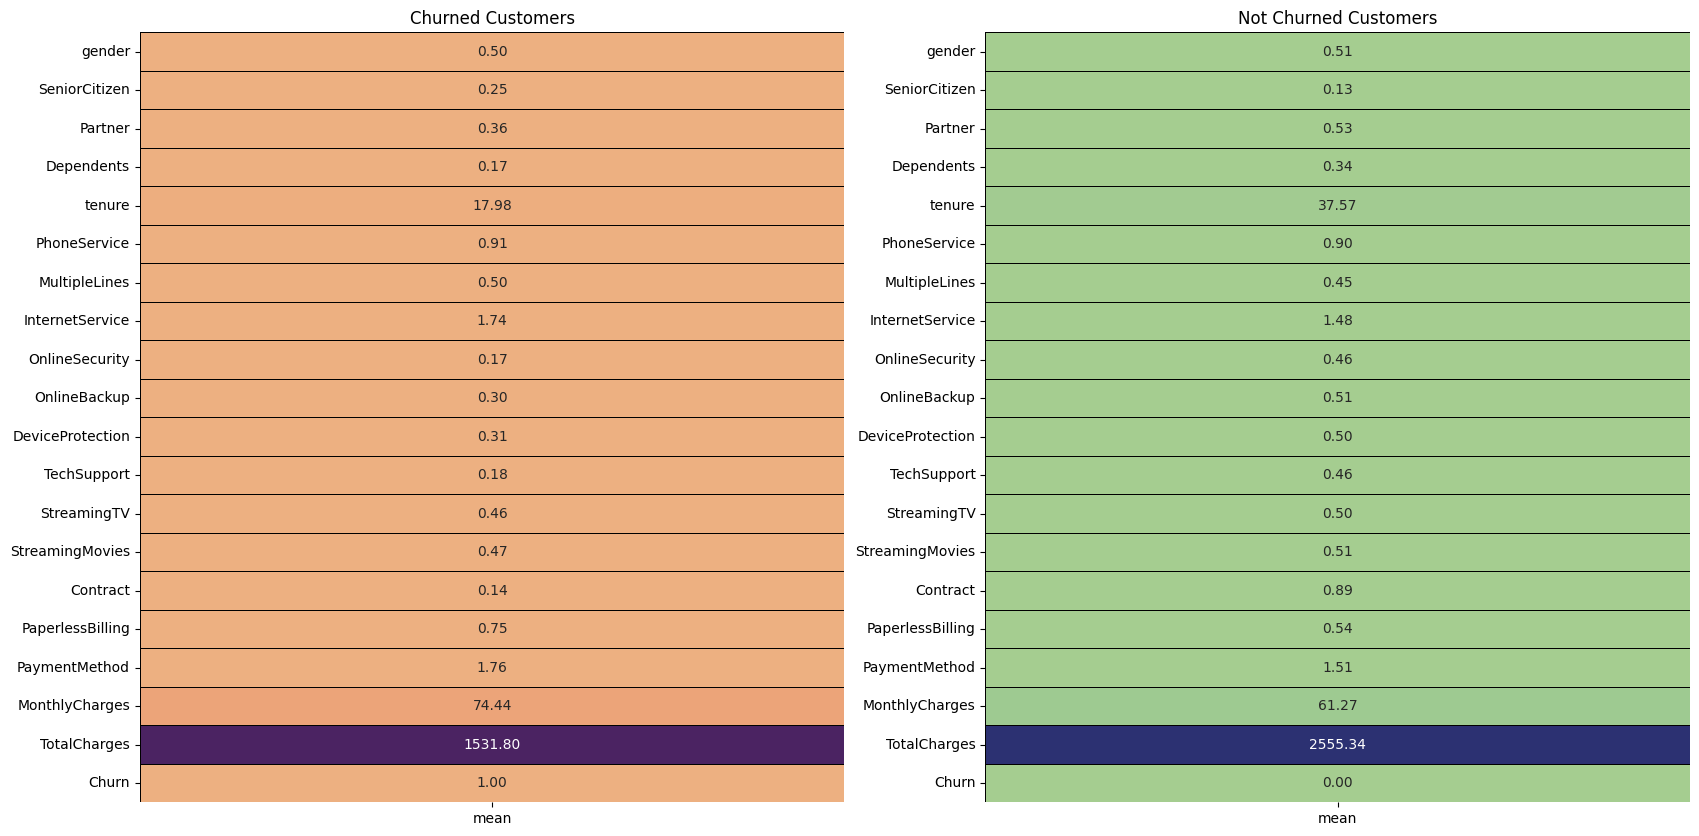

In [14]:
fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (20,10))

plt.subplot(1, 2, 1)
sns.heatmap(churn[['mean']], annot=True, linewidths=0.4, linecolor='black', cbar=False, fmt='.2f', cmap='flare')
plt.title('Churned Customers')

# heatmap for not churned customers
plt.subplot(1, 2, 2)
sns.heatmap(not_churn[['mean']], annot=True, linewidths=0.4, linecolor='black', cbar=False, fmt='.2f', cmap='crest')
plt.title('Not Churned Customers')

plt.show()

#### Mean values of all the features for churned and not-churned customers:
- The customers that churned had a low mean tenure of 17.98 months as compared to those who continued with an average tenure period of 37.57 months.
- Mean values of OnlineSecurity, OnlineBackup, DeviceProtection and TechSupport are higher for not-churned customers than churn customers. This can serve as a good indicator or point to focus on
- Churned customer's Contract value is much smaller than those of not-churned customers.
- Mean MonthlyCharges of the churn customers, 74.44, is more than that of not-churn customers, 61.27.
- Not-churned customers TotalCharges, 2557.31, is higher than churn customers, 1531.80.
- From these mean values, we can say that some of the features display a clear cut difference that can help to focus more churn customers to make sure they retain the services.
- The dataset has too many categorical features, hence mean values of the features are present in the vicinity of 0.

#### To get a better view of the range of the churn versus not_churned range of values, we can clip the total charges or use a log scale to better see the differences

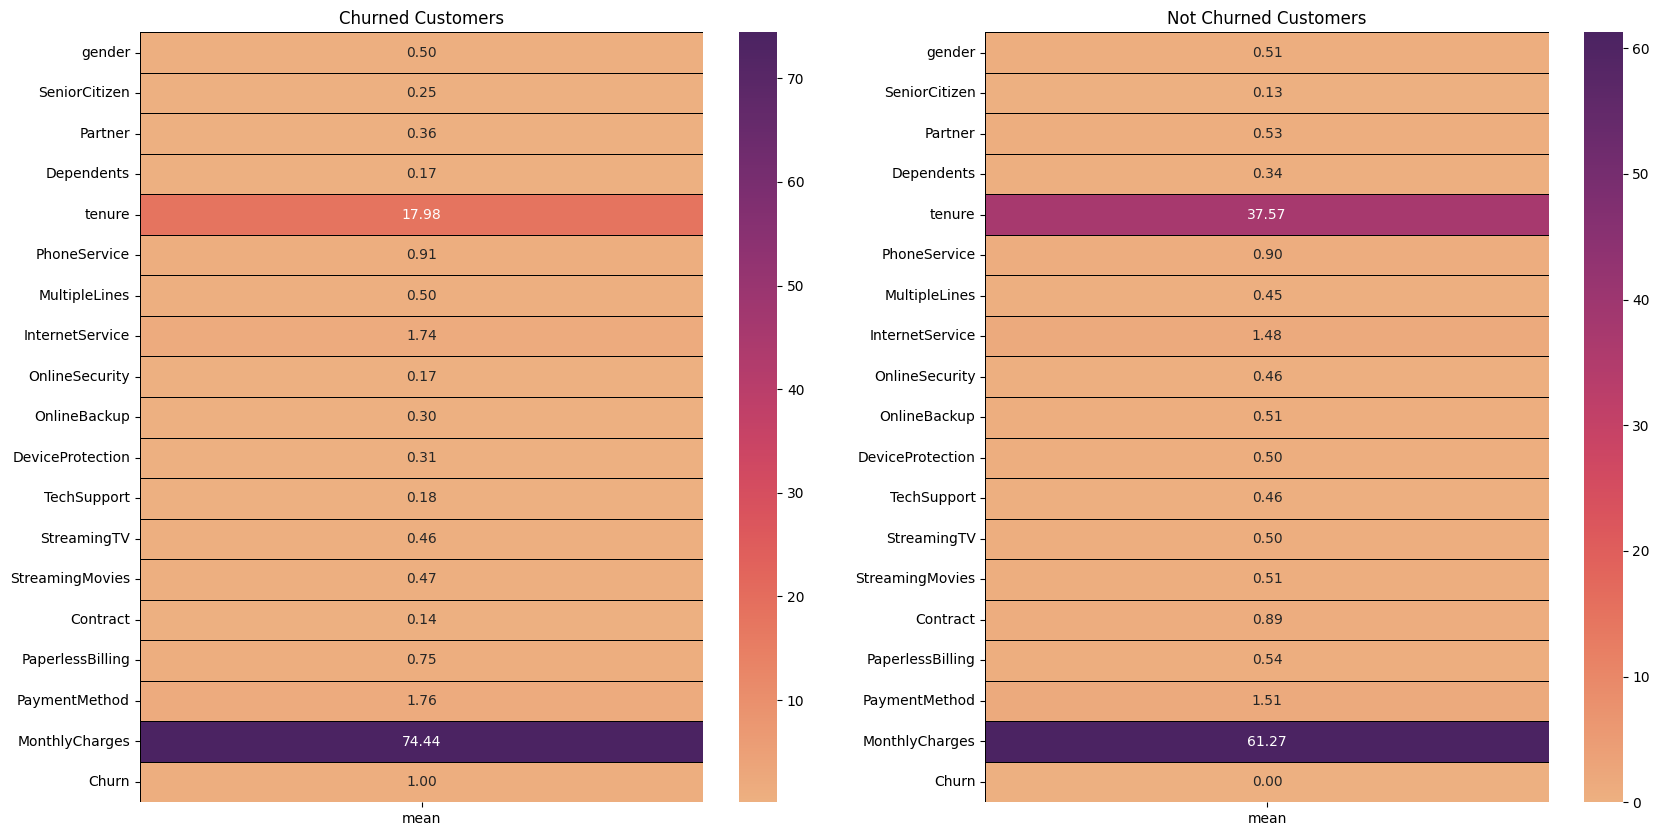

In [15]:
threshold = 100

# Drop rows above the threshold
churn = churn[churn['mean'] <= threshold]
not_churn = not_churn[not_churn['mean'] <= threshold]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(churn[['mean']], annot=True, linewidths=0.4, linecolor='black', cbar=True, fmt='.2f', cmap='flare')
plt.title('Churned Customers')

plt.subplot(1, 2, 2)
sns.heatmap(not_churn[['mean']], annot=True, linewidths=0.4, linecolor='black', cbar=True, fmt='.2f', cmap='flare')
plt.title('Not Churned Customers')

plt.show()

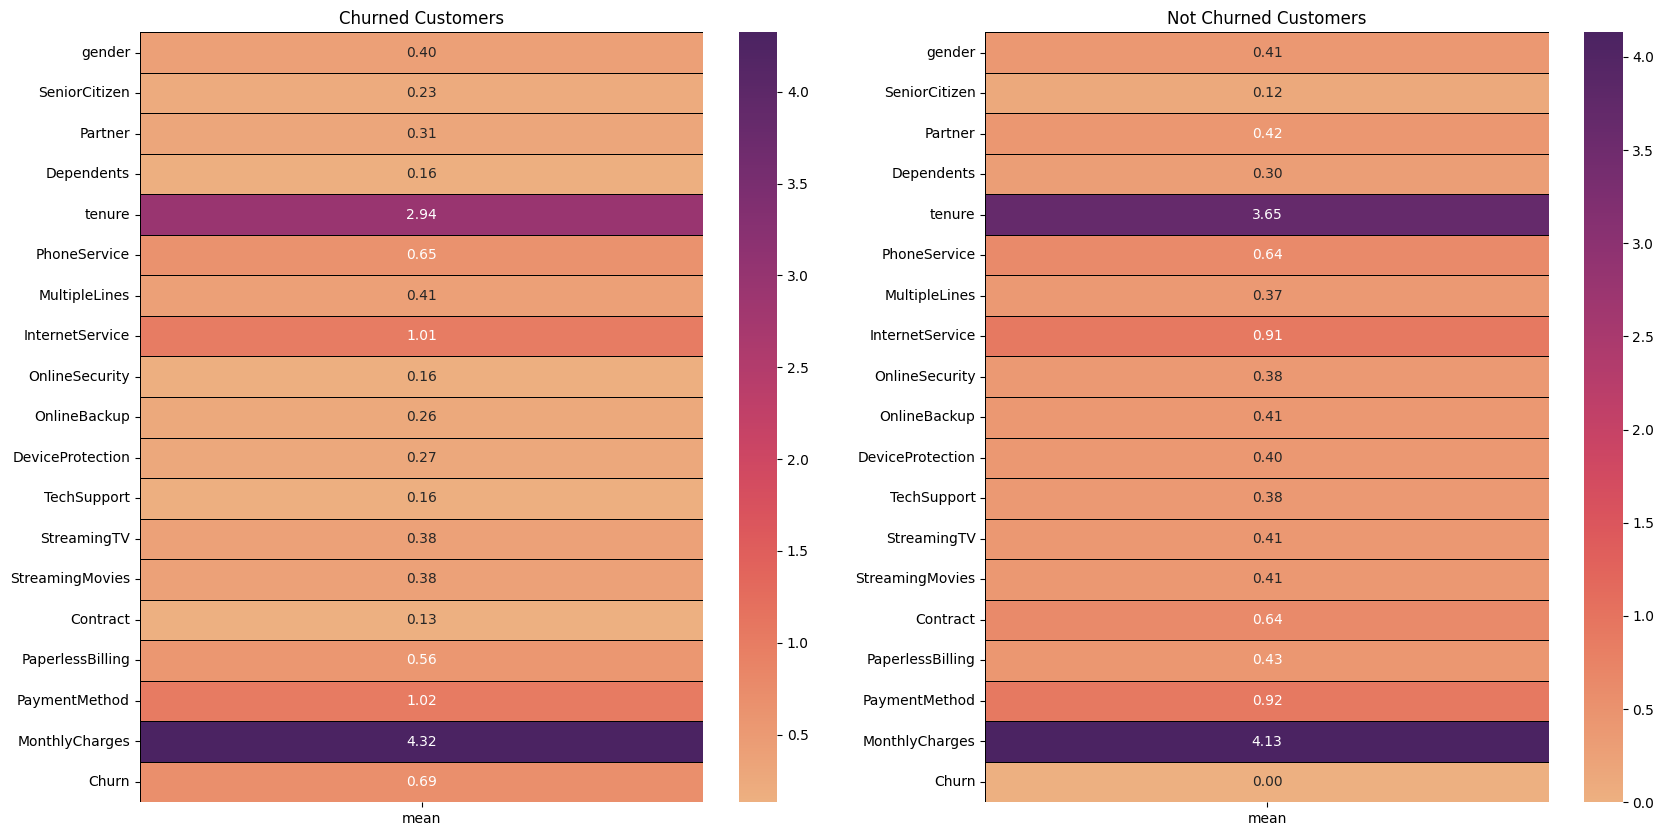

In [16]:
# logarithmic transformation 
churn['mean'] = np.log1p(churn['mean'])
not_churn['mean'] = np.log1p(not_churn['mean'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(churn[['mean']], annot=True, linewidths=0.4, linecolor='black', cbar=True, fmt='.2f', cmap='flare')
plt.title('Churned Customers')

plt.subplot(1, 2, 2)
sns.heatmap(not_churn[['mean']], annot=True, linewidths=0.4, linecolor='black', cbar=True, fmt='.2f', cmap='flare')
plt.title('Not Churned Customers')

plt.show()

# Exploratory Data Analysis

#### Dividing features into Numerical and Categorical:

In [17]:
col = list(df2.columns)
categorical_features = []
numerical_features = []
for i in col:
    # Using our original df copy as a reference
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : gender SeniorCitizen Partner Dependents PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies Contract PaperlessBilling PaymentMethod Churn
Numerical Features : customerID tenure MonthlyCharges TotalCharges


Categorical features are defined if the the attribute has less than 6 unique elements else it is a numerical feature.

For this dataset, as the number of features are less, we can manually check the dataset as well.

#### Target Variable Visualization (Churn):

In [18]:
# churn / no-churn 
churn_values = list(df2['Churn'].value_counts())
churn_percentages = [churn_values[0] / sum(churn_values) * 100,churn_values[1] / sum(churn_values) * 100]

print(churn_values)
print(churn_percentages)

[5174, 1869]
[73.4630129206304, 26.536987079369588]


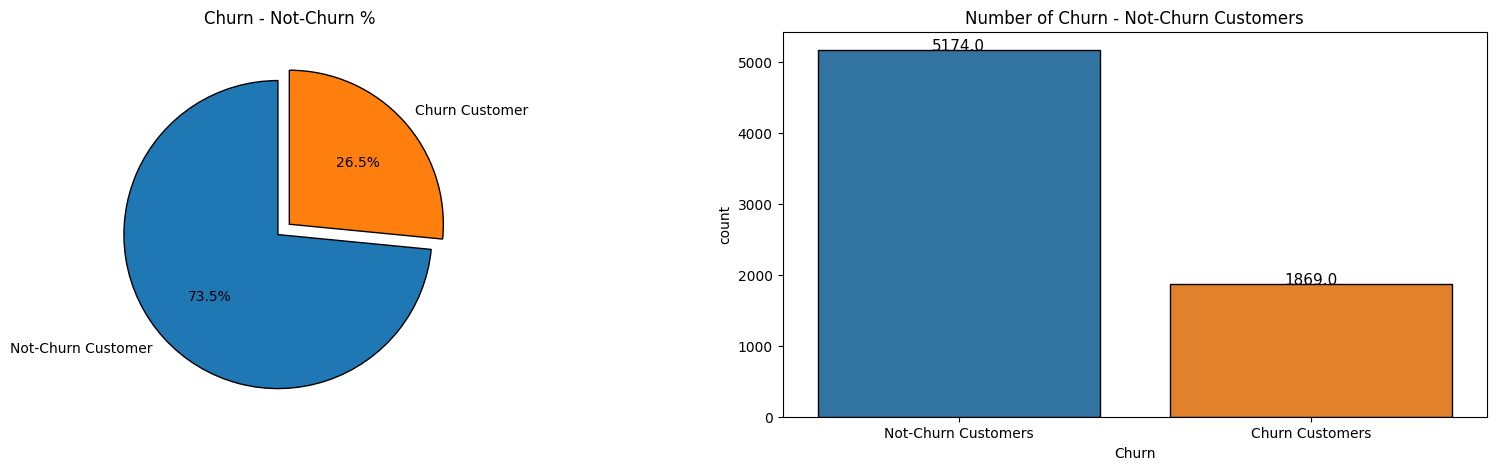

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axes[0].pie(churn_percentages, labels=['Not-Churn Customer', 'Churn Customer'], autopct='%1.1f%%', startangle=90, explode=(0.1, 0),
            wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[0].set_title('Churn - Not-Churn %')

ax = sns.countplot(x='Churn', data=df, edgecolor='black', ax=axes[1])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
ax.set_xticklabels(['Not-Churn Customers', 'Churn Customers'])
axes[1].set_title('Number of Churn - Not-Churn Customers')

plt.show()

We should be aware that since our data shows a bias towards `Not-Churn` customer (3:1 ratio), becasue of this, predictins will be biased towards 'Not-Churn'.

### Categorical Features vs Target Variable (Churn):

In [20]:
categorical_features.remove('Churn')

We will remove Churn, target variable, from the categorical features list for visualization purposes.

In [21]:
list1 = ['gender','SeniorCitizen','Partner','Dependents'] # Customer Information
list2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!
list3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information

We have too many categorical features so we'll divide them into 3 groups depending on their values or based on the column name

Customer Information (Group 1):

Gender | SeniorCitizen | Partner | Dependents |

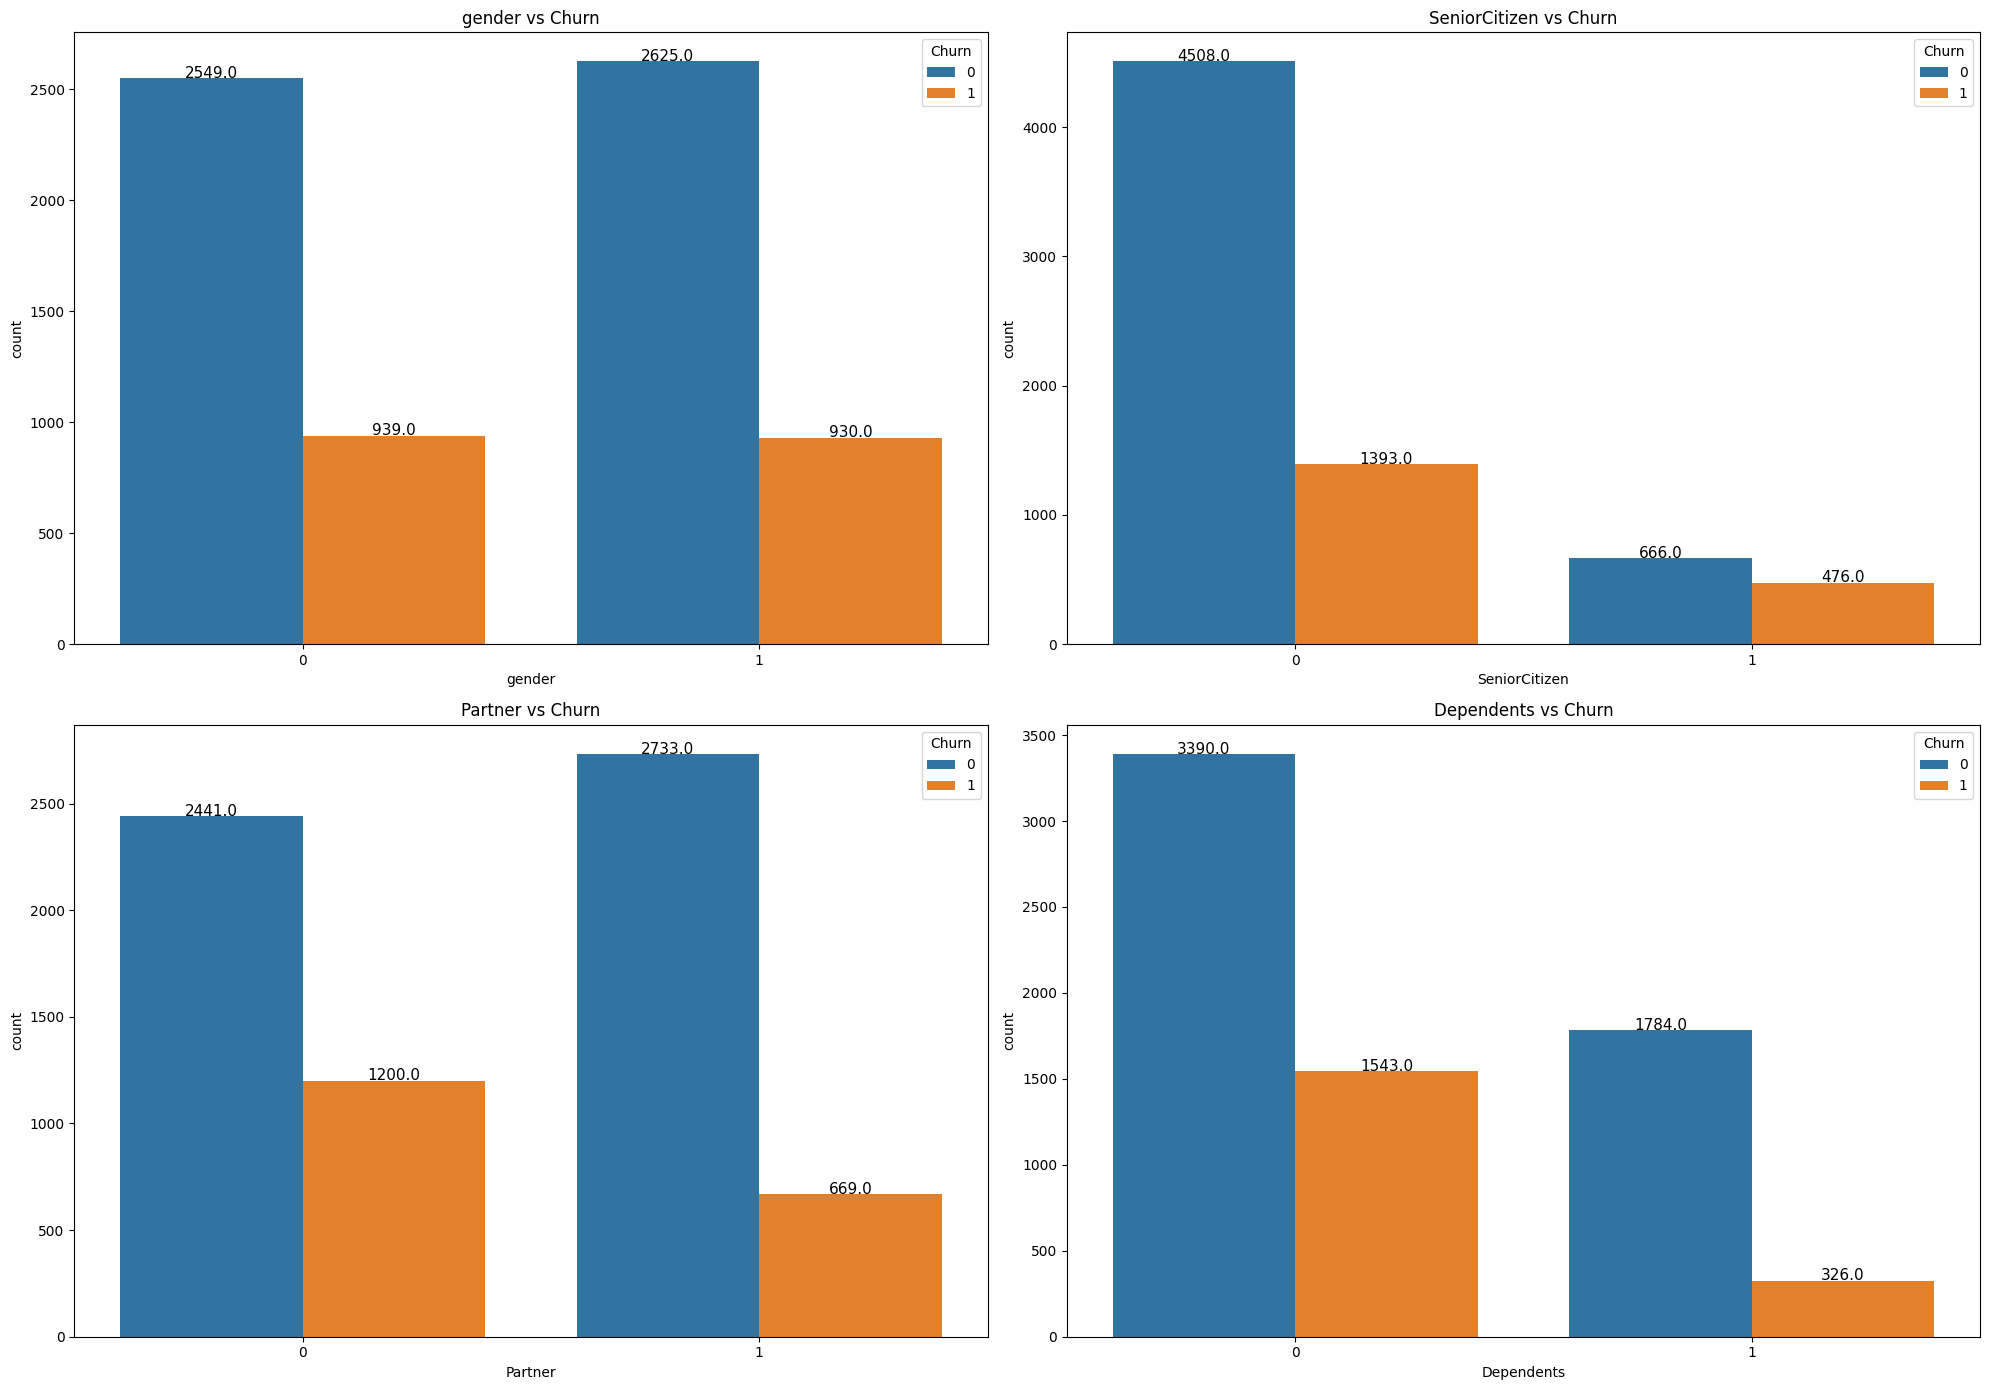

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))

for i in range(len(list1)):
    plt.subplot(2, 2, i + 1)
    ax = sns.countplot(x=list1[i], data=df, hue="Churn", ax=axes[i // 2, i % 2]) 

    for rect in ax.patches:
        ax.text(
            rect.get_x() + rect.get_width() / 2, 
            rect.get_height() + 2, 
            rect.get_height(), 
            horizontalalignment='center', 
            fontsize=11
        )
    
    title = list1[i] + ' vs Churn'
    ax.set_title(title)

plt.tight_layout()  
plt.show()


- Customer churning for male & female customers are very similar
- Similarly, number of SeniorCitizen customers is pretty low. We can see that about 40% churn of SeniorCitizen customers. It accounts for a total of 476 customers out of 1142 Senior Citizen customers.
- Customers who are housing with a Partner churned less as compared to those not living with a Partner.
- Churning is high for the customers that don't have Dependents

Services Subscribed by the Customer (Group 2):

For visualization purposes, we will create 2 groups

PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies |

In [23]:
# Convert categorical to string type before filling NaNs
for col in list2:
    if pd.api.types.is_integer_dtype(df[col]):
        df[col] = df[col].fillna(-1)  
    else:
        df[col] = df[col].astype(str).fillna('Unknown')

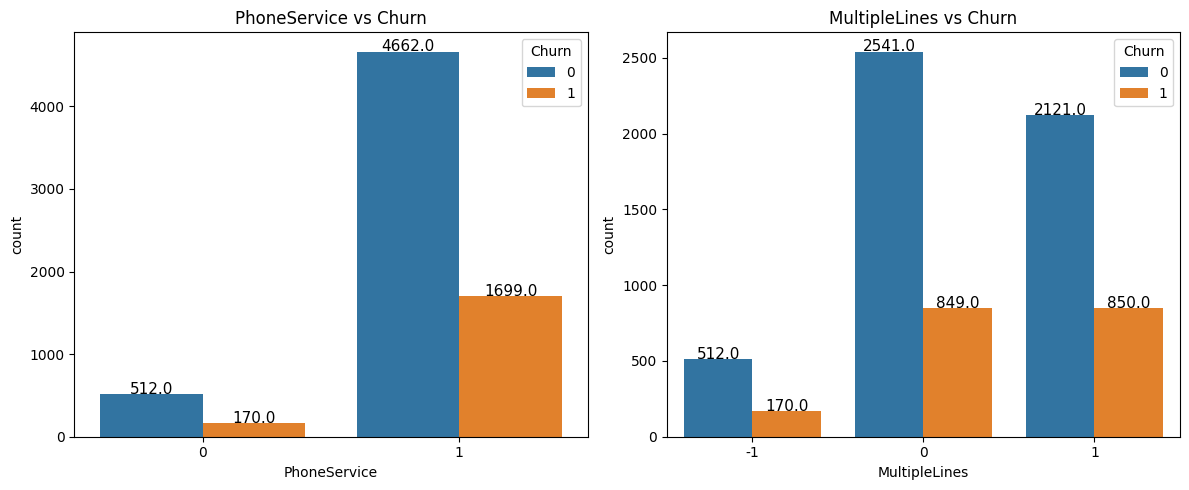

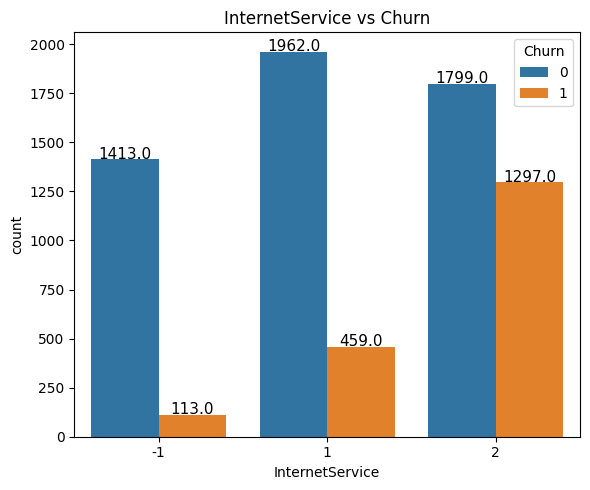

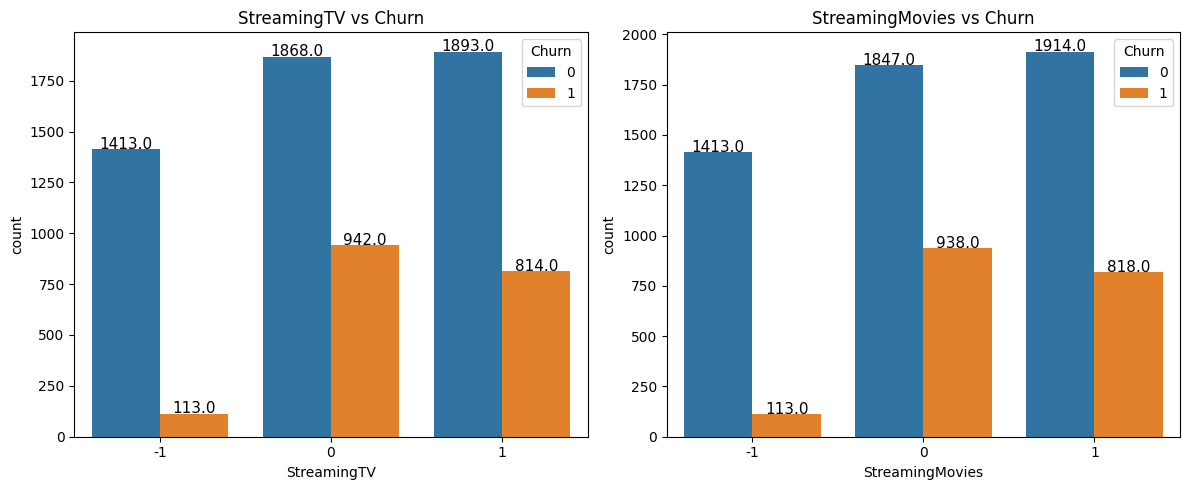

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i in range(2): 
    ax = sns.countplot(x=list2[i], data=df, hue="Churn", ax=axes[i])
    for rect in ax.patches:
        ax.text(
            rect.get_x() + rect.get_width() / 2, 
            rect.get_height() + 2, 
            rect.get_height(), 
            horizontalalignment='center', 
            fontsize=11
        )
    ax.set_title(f"{list2[i]} vs Churn")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
ax = sns.countplot(x=list2[2], data=df, hue="Churn", ax=ax)
for rect in ax.patches:
    ax.text(
        rect.get_x() + rect.get_width() / 2, 
        rect.get_height() + 2, 
        rect.get_height(), 
        horizontalalignment='center', 
        fontsize=11
    )
ax.set_title(f"{list2[2]} vs Churn")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i in range(2):  # loop over list2[3:5]
    ax = sns.countplot(x=list2[i + 3], data=df, hue="Churn", ax=axes[i])
    for rect in ax.patches:
        ax.text(
            rect.get_x() + rect.get_width() / 2, 
            rect.get_height() + 2, 
            rect.get_height(), 
            horizontalalignment='center', 
            fontsize=11
        )
    ax.set_title(f"{list2[i + 3]} vs Churn")
plt.tight_layout()
plt.show()



- For PhoneService, despite having no phone service, more customers were retained as compared to the number of customers who dropped the services.
- In case of MultipleLines, churn rate in when the Multiplelines are present or not is the same.
- A high number of customers have displayed their resistance towards the use of Fiber optic cables for providing the InternetService. On the contrary, from the above graph, customers prefer using DSL for their InternetService
- StreamingTV and StreamingMovies display an identical graph. Irrespective of being subscribed to StreamingTV & StreamingMovies, a lot of customers have been churned. Looks like the streaming content was not entirely at fault

Services Subscribed by the Customer (Group 2):

OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport |

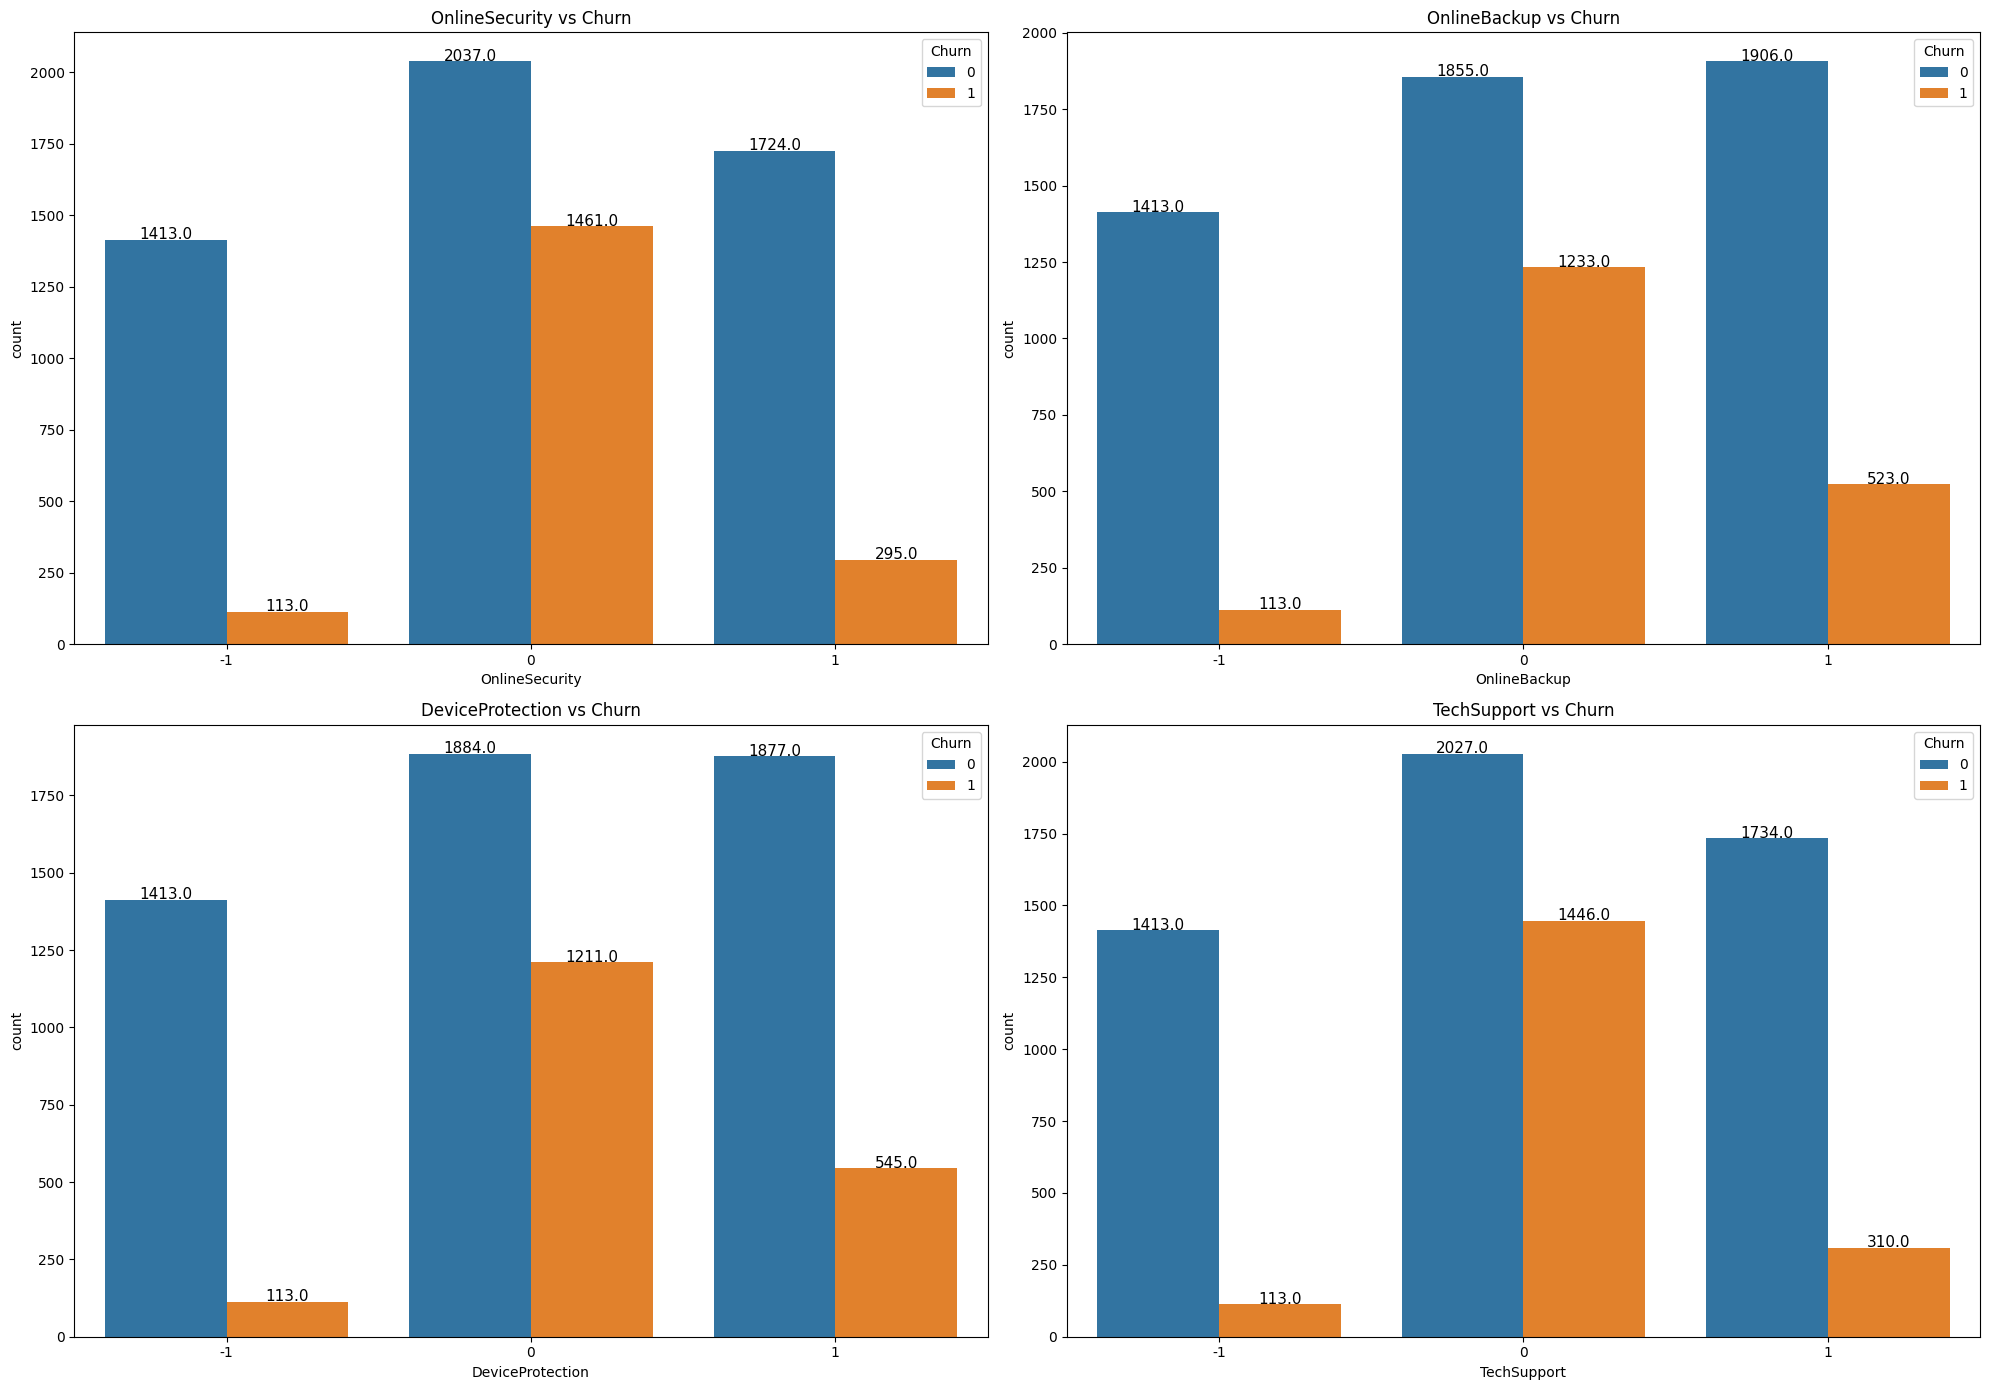

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))
for i in range(4):  # Loop over the last 4 elements in list2
    ax = sns.countplot(x=list2[-4 + i], data=df, hue="Churn", ax=axes[i // 2, i % 2])
    
    for rect in ax.patches:
        ax.text(
            rect.get_x() + rect.get_width() / 2, 
            rect.get_height() + 2, 
            rect.get_height(), 
            horizontalalignment='center', 
            fontsize=11
        )
    
    ax.set_title(f"{list2[-4 + i]} vs Churn")

plt.tight_layout()  
plt.show()


A high number of customers have switched their service provider when it comes down poor services with  OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport

Group 3 : Contract | PaperlessBilling | PaymentMethod |

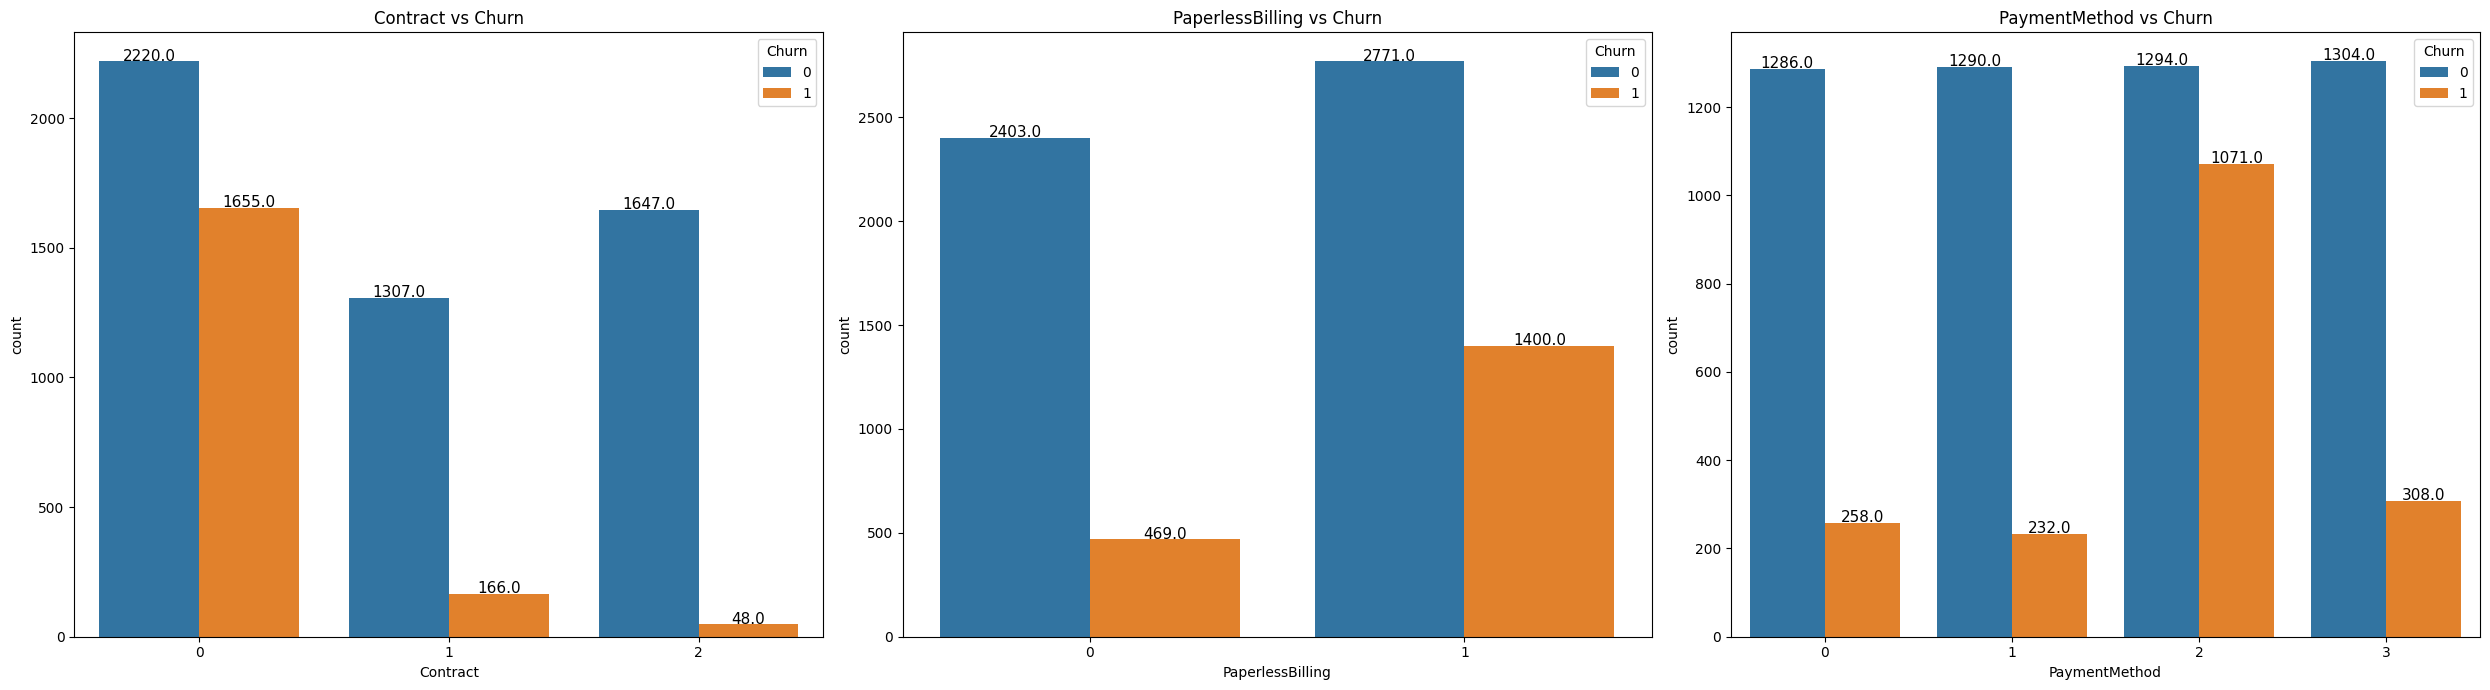

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))

ax = sns.countplot(x=list3[0], data=df, hue="Churn", ax=axes[0])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), 
            horizontalalignment='center', fontsize=11)
ax.set_title(f"{list3[0]} vs Churn")

ax = sns.countplot(x=list3[1], data=df, hue="Churn", ax=axes[1])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), 
            horizontalalignment='center', fontsize=11)
ax.set_title(f"{list3[1]} vs Churn")

ax = sns.countplot(x=list3[2], data=df, hue="Churn", ax=axes[2])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), 
            horizontalalignment='center', fontsize=11)
ax.set_title(f"{list3[2]} vs Churn")

plt.tight_layout()
plt.show()


- Customer churning for a Month-to-Month based Contract is quite high. This is probably because the customers are testing out the varied services available.
- PaperlessBilling displays a high number of customers being churned out. This is probably because of some payment issue
- Of the 2365 number of bills paid using Electronic check, 1071 customers exited the  service due to this payment method. Company definitely needs to either drop Electronic check method or make it hassle-free and user-friendly.

## Categorical Features vs Positive Target Variable (Churn Cases)


Customer Information (Group 1):

gender | SeniorCitizen | Partner | Dependents |

In [27]:
gender = df[df['Churn'] == 1]['gender'].value_counts()
gender = [gender[0] / sum(gender) * 100, gender[1] / sum(gender) * 100]

seniorcitizen = df[df['Churn'] == 1]['SeniorCitizen'].value_counts()
seniorcitizen = [seniorcitizen[0] / sum(seniorcitizen) * 100,seniorcitizen[1] / sum(seniorcitizen) * 100] 

partner = df[df['Churn'] == 1]['Partner'].value_counts()
partner = [partner[0] / sum(partner) * 100,partner[1] / sum(partner) * 100] 

dependents = df[df['Churn'] == 1]['Dependents'].value_counts()
dependents = [dependents[0] / sum(dependents) * 100,dependents[1] / sum(dependents) * 100] 

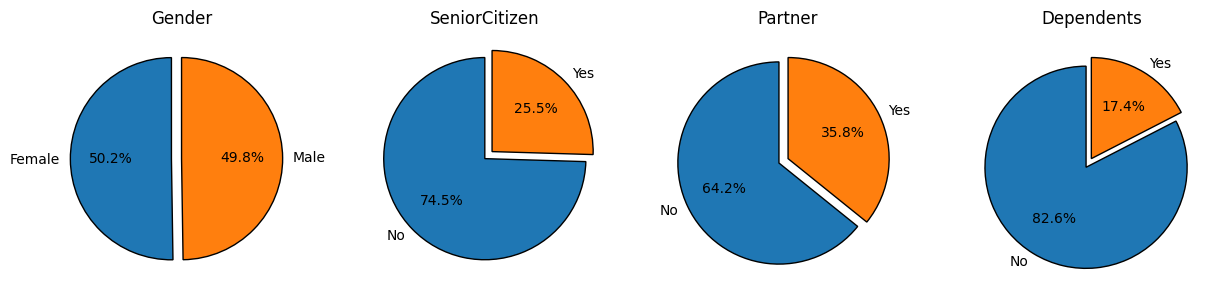

In [28]:
ax,fig = plt.subplots(nrows = 1,ncols = 4,figsize = (15,15))

plt.subplot(1,4,1)
plt.pie(gender,labels = ['Female','Male'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Gender');

plt.subplot(1,4,2)
plt.pie(seniorcitizen,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('SeniorCitizen');

plt.subplot(1,4,3)
plt.pie(partner,labels = ['No','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Partner');

plt.subplot(1,4,4)
plt.pie(dependents,labels = ['No','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Dependents');


- We have 50% - 50% split between the male and female customers that have switched their services. Hence, the reason for switching is something related to the service and not gender.
- 75% of the churned customers are not SeniorCitizen This is a major info that the company needs to divert it's attention to.
- 73.4% of customers churned out were living by themselves.


Services Subscribed by the Customer (Group 2):

PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies |

In [29]:
# PhoneService percentages
phoneservice = df[df['Churn'] == 1]['PhoneService'].value_counts()
phoneservice = [
    phoneservice.get(0, 0) / sum(phoneservice) * 100, 
    phoneservice.get(1, 0) / sum(phoneservice) * 100
]

#  MultipleLines percentages
multiplelines = df[df['Churn'] == 1]['MultipleLines'].value_counts()
multiplelines = [
    multiplelines.get(0, 0) / sum(multiplelines) * 100,
    multiplelines.get(1, 0) / sum(multiplelines) * 100,
    multiplelines.get(2, 0) / sum(multiplelines) * 100
]

# InternetService percentages 
internetservice = df[df['Churn'] == 1]['InternetService'].value_counts()
internetservice = [
    internetservice.get(0, 0) / sum(internetservice) * 100,
    internetservice.get(1, 0) / sum(internetservice) * 100,
    internetservice.get(2, 0) / sum(internetservice) * 100
]

# StreamingTV percentages
streamingtv = df[df['Churn'] == 1]['StreamingTV'].value_counts()
streamingtv = [
    streamingtv.get(0, 0) / sum(streamingtv) * 100,
    streamingtv.get(1, 0) / sum(streamingtv) * 100,
    streamingtv.get(2, 0) / sum(streamingtv) * 100
]

# StreamingMovies percentages 
streamingmovies = df[df['Churn'] == 1]['StreamingMovies'].value_counts()
streamingmovies = [
    streamingmovies.get(0, 0) / sum(streamingmovies) * 100,
    streamingmovies.get(1, 0) / sum(streamingmovies) * 100,
    streamingmovies.get(2, 0) / sum(streamingmovies) * 100
]

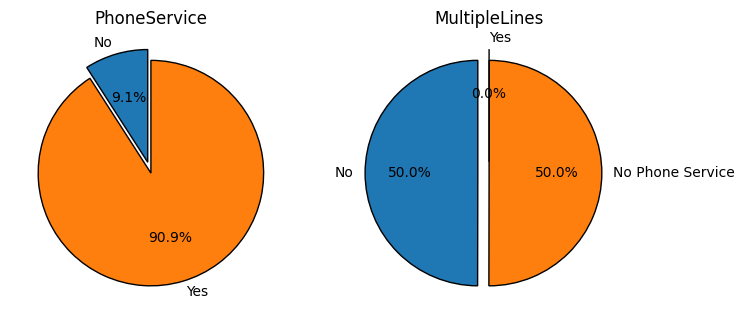

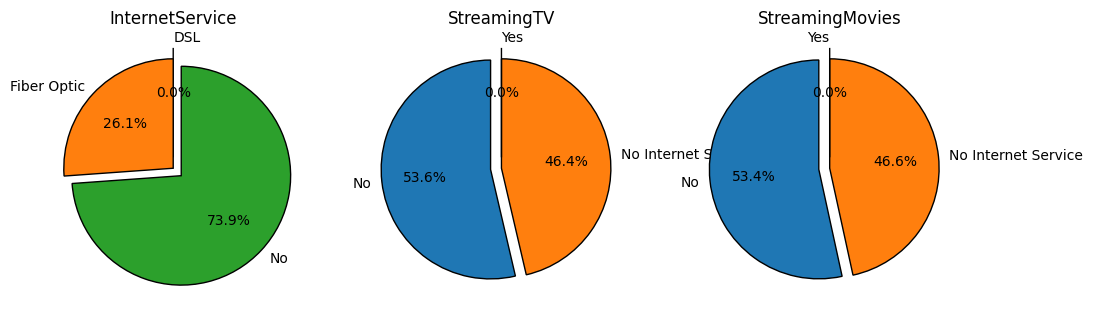

In [30]:
ax,fig = plt.subplots(nrows = 1,ncols = 2,figsize = (8,8))

plt.subplot(1,2,1)
plt.pie(phoneservice,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PhoneService');

plt.subplot(1,2,2)
plt.pie(multiplelines,labels = ['No','No Phone Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('MultipleLines');

ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (12,12))

plt.subplot(1,3,1)
plt.pie(internetservice,labels = ['DSL', 'Fiber Optic','No'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('InternetService');

plt.subplot(1,3,2)
plt.pie(streamingtv,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingTV');

plt.subplot(1,3,3)
plt.pie(streamingmovies,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingMovies');


- Despite providing PhoneService, a high percentage of customers switched
- Similarly, availability of MultipleLines did not matter.
- Customers definitely did not appreciate the approach of Fiber Optic cables for providing InternetService with a solid 70% opting out.
- For StreamingTV & StreamingMovies, customers without these services definitely cancelled their subscription, however an average of 46.6% of customers switched despite consuming the streaming content.

Services Subscribed by the Customer (Group 2):

OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport |

In [31]:
onlinesecurity = df[df['Churn'] == 1]['OnlineSecurity'].value_counts()
onlinesecurity = [
    onlinesecurity.get('No', 0) / sum(onlinesecurity) * 100,
    onlinesecurity.get('No Internet Service', 0) / sum(onlinesecurity) * 100,
    onlinesecurity.get('Yes', 0) / sum(onlinesecurity) * 100
]

onlinebackup = df[df['Churn'] == 1]['OnlineBackup'].value_counts()
onlinebackup = [
    onlinebackup.get('No', 0) / sum(onlinebackup) * 100,
    onlinebackup.get('No Internet Service', 0) / sum(onlinebackup) * 100,
    onlinebackup.get('Yes', 0) / sum(onlinebackup) * 100
]

deviceprotection = df[df['Churn'] == 1]['DeviceProtection'].value_counts()
deviceprotection = [
    deviceprotection.get('No', 0) / sum(deviceprotection) * 100,
    deviceprotection.get('No Internet Service', 0) / sum(deviceprotection) * 100,
    deviceprotection.get('Yes', 0) / sum(deviceprotection) * 100
]

techsupport = df[df['Churn'] == 1]['TechSupport'].value_counts()
techsupport = [
    techsupport.get('No', 0) / sum(techsupport) * 100,
    techsupport.get('No Internet Service', 0) / sum(techsupport) * 100,
    techsupport.get('Yes', 0) / sum(techsupport) * 100
]

In [32]:
#percentages with category checking
onlinesecurity = df[df['Churn'] == 1]['OnlineSecurity'].value_counts()
onlinesecurity_percentages = [
    onlinesecurity.get('No', 0) / sum(onlinesecurity) * 100,
    onlinesecurity.get('No Internet Service', 0) / sum(onlinesecurity) * 100,
    onlinesecurity.get('Yes', 0) / sum(onlinesecurity) * 100
]
print("OnlineSecurity percentages:", onlinesecurity_percentages)

onlinebackup = df[df['Churn'] == 1]['OnlineBackup'].value_counts()
onlinebackup_percentages = [
    onlinebackup.get('No', 0) / sum(onlinebackup) * 100,
    onlinebackup.get('No Internet Service', 0) / sum(onlinebackup) * 100,
    onlinebackup.get('Yes', 0) / sum(onlinebackup) * 100
]
print("OnlineBackup percentages:", onlinebackup_percentages)

deviceprotection = df[df['Churn'] == 1]['DeviceProtection'].value_counts()
deviceprotection_percentages = [
    deviceprotection.get('No', 0) / sum(deviceprotection) * 100,
    deviceprotection.get('No Internet Service', 0) / sum(deviceprotection) * 100,
    deviceprotection.get('Yes', 0) / sum(deviceprotection) * 100
]
print("DeviceProtection percentages:", deviceprotection_percentages)

techsupport = df[df['Churn'] == 1]['TechSupport'].value_counts()
techsupport_percentages = [
    techsupport.get('No', 0) / sum(techsupport) * 100,
    techsupport.get('No Internet Service', 0) / sum(techsupport) * 100,
    techsupport.get('Yes', 0) / sum(techsupport) * 100
]
#print("TechSupport percentages:", techsupport_percentages)

OnlineSecurity percentages: [0.0, 0.0, 0.0]
OnlineBackup percentages: [0.0, 0.0, 0.0]
DeviceProtection percentages: [0.0, 0.0, 0.0]


In [33]:
# Convert columns to regular ints and apply mapping
df['OnlineSecurity'] = df['OnlineSecurity'].astype('int').map({0: 'No', 1: 'Yes', -1: 'No Internet Service'})
df['OnlineBackup'] = df['OnlineBackup'].astype('int').map({0: 'No', 1: 'Yes', -1: 'No Internet Service'})
df['DeviceProtection'] = df['DeviceProtection'].astype('int').map({0: 'No', 1: 'Yes', -1: 'No Internet Service'})
df['TechSupport'] = df['TechSupport'].astype('int').map({0: 'No', 1: 'Yes', -1: 'No Internet Service'})

# recalculate
onlinesecurity = df[df['Churn'] == 1]['OnlineSecurity'].value_counts(normalize=True).reindex(['No', 'No Internet Service', 'Yes']).fillna(0) * 100
onlinebackup = df[df['Churn'] == 1]['OnlineBackup'].value_counts(normalize=True).reindex(['No', 'No Internet Service', 'Yes']).fillna(0) * 100
deviceprotection = df[df['Churn'] == 1]['DeviceProtection'].value_counts(normalize=True).reindex(['No', 'No Internet Service', 'Yes']).fillna(0) * 100
techsupport = df[df['Churn'] == 1]['TechSupport'].value_counts(normalize=True).reindex(['No', 'No Internet Service', 'Yes']).fillna(0) * 100

#print("OnlineSecurity percentages:", onlinesecurity)
#print("OnlineBackup percentages:", onlinebackup)
#print("DeviceProtection percentages:", deviceprotection)
#print("TechSupport percentages:", techsupport)

In [34]:
#print("OnlineSecurity with Churn == 1:\n", df[df['Churn'] == 1]['OnlineSecurity'].value_counts(dropna=False))
#print("OnlineBackup with Churn == 1:\n", df[df['Churn'] == 1]['OnlineBackup'].value_counts(dropna=False))
#print("DeviceProtection with Churn == 1:\n", df[df['Churn'] == 1]['DeviceProtection'].value_counts(dropna=False))
#print("TechSupport with Churn == 1:\n", df[df['Churn'] == 1]['TechSupport'].value_counts(dropna=False))

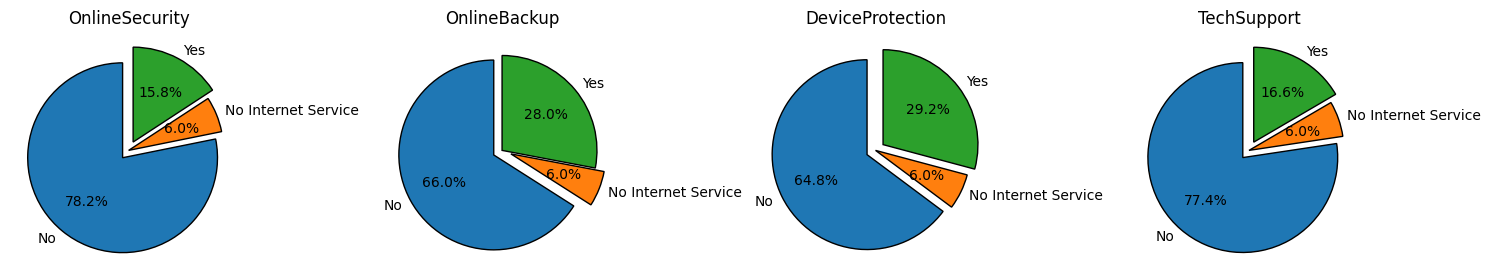

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))

axes[0].pie(onlinesecurity, labels=['No', 'No Internet Service', 'Yes'], autopct='%1.1f%%', startangle=90,
            explode=(0.1, 0, 0.1), wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[0].set_title('OnlineSecurity')

axes[1].pie(onlinebackup, labels=['No', 'No Internet Service', 'Yes'], autopct='%1.1f%%', startangle=90,
            explode=(0.1, 0.1, 0), wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[1].set_title('OnlineBackup')

axes[2].pie(deviceprotection, labels=['No', 'No Internet Service', 'Yes'], autopct='%1.1f%%', startangle=90,
            explode=(0.1, 0, 0.1), wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[2].set_title('DeviceProtection')

axes[3].pie(techsupport, labels=['No', 'No Internet Service', 'Yes'], autopct='%1.1f%%', startangle=90,
            explode=(0.1, 0, 0.1), wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[3].set_title('TechSupport')

plt.tight_layout()
plt.show()

The pie charts stress out the significance of providing OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport as an average of 71.6% customers cutoff their services due to lack of these features

Group 3 : 

Contract | PaperlessBilling | PaymentMethod |

In [36]:
# mappings for each column
contract_mapping = {0: 'Month-to-month', 1: 'One year', 2: 'Two year'}
paperlessbilling_mapping = {0: 'No', 1: 'Yes'}
paymentmethod_mapping = {0: 'Electronic check', 1: 'Mailed check', 2: 'Bank transfer', 3: 'Credit card'}

df['Contract'] = df['Contract'].map(contract_mapping)
df['PaperlessBilling'] = df['PaperlessBilling'].map(paperlessbilling_mapping)
df['PaymentMethod'] = df['PaymentMethod'].map(paymentmethod_mapping)

contract = df[df['Churn'] == 1]['Contract'].value_counts(normalize=True).reindex(['Month-to-month', 'One year', 'Two year']).fillna(0) * 100
paperlessbilling = df[df['Churn'] == 1]['PaperlessBilling'].value_counts(normalize=True).reindex(['No', 'Yes']).fillna(0) * 100
paymentmethod = df[df['Churn'] == 1]['PaymentMethod'].value_counts(normalize=True).reindex(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card']).fillna(0) * 100

#print("Contract percentages:", contract.tolist())
#print("PaperlessBilling percentages:", paperlessbilling.tolist())
#print("PaymentMethod percentages:", paymentmethod.tolist())

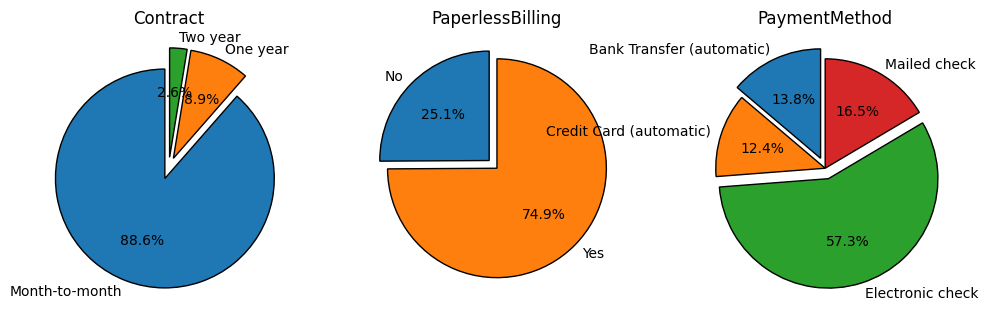

In [37]:
ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (12,12))

plt.subplot(1,3,1)
plt.pie(contract,labels = ['Month-to-month','One year','Two year'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0.1,0.1),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Contract');

plt.subplot(1,3,2)
plt.pie(paperlessbilling,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PaperlessBilling');

plt.subplot(1,3,3)
plt.pie(paymentmethod,labels = ['Bank Transfer (automatic)','Credit Card (automatic)','Electronic check','Mailed check'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1,0),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PaymentMethod');

- Month-to-Month Contract duration has the dominating share when it comes churning with a massive 88.6% customers
- PaperlessBilling does seems to be appreciated by the customers
- Electronic check definitely needs to be sorted as it accounts for 57.3% of churn. 

## Numerical Features :

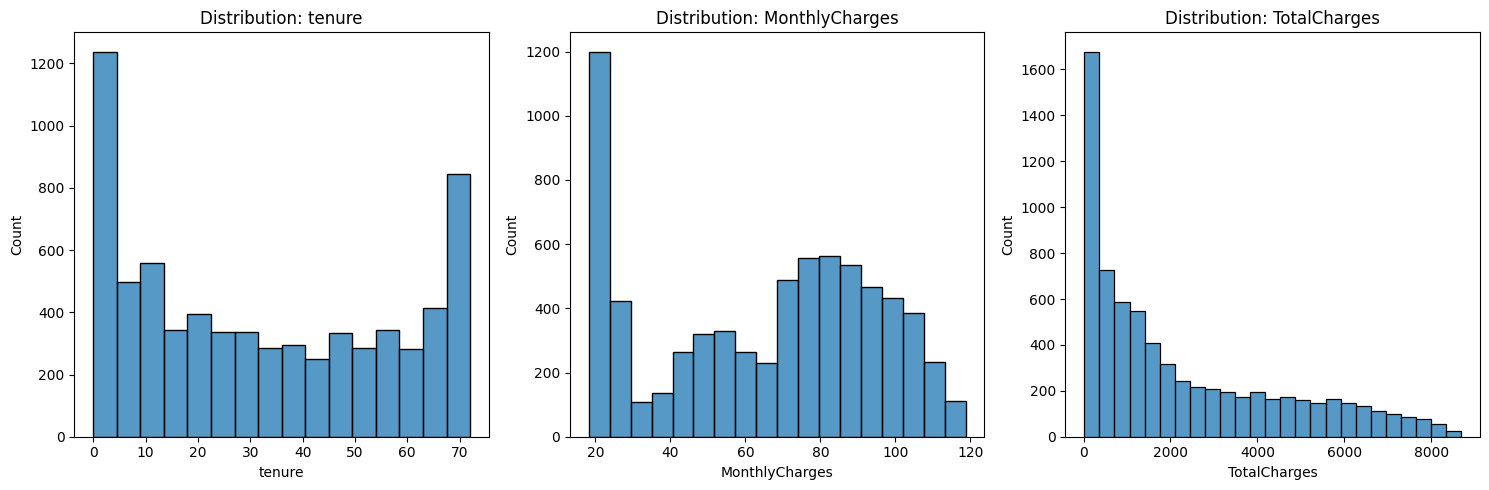

In [38]:
# drop 'customerID' 
numerical_features = [feature for feature in numerical_features if feature != 'customerID']

# NaN values 
for feature in numerical_features:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')

# Replace NaNs 
df_cleaned = df[numerical_features].fillna(df[numerical_features].median())

fig, ax = plt.subplots(nrows=1, ncols=len(numerical_features), figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    sns.histplot(df_cleaned[feature], kde=False, ax=ax[i])  # KDE=False to avoid sqrt issues
    ax[i].set_title(f'Distribution: {feature}')

plt.tight_layout()
plt.show()

- tenure and MonthlyCharges kind of create a bimodal distribution with peaks present at 0 - 70 and 20 - 80 respectively.
- TotalCharges displays a positively or rightly skewed distribution.

### Numerical Features w/ respect to Target Variable (Outcome) :

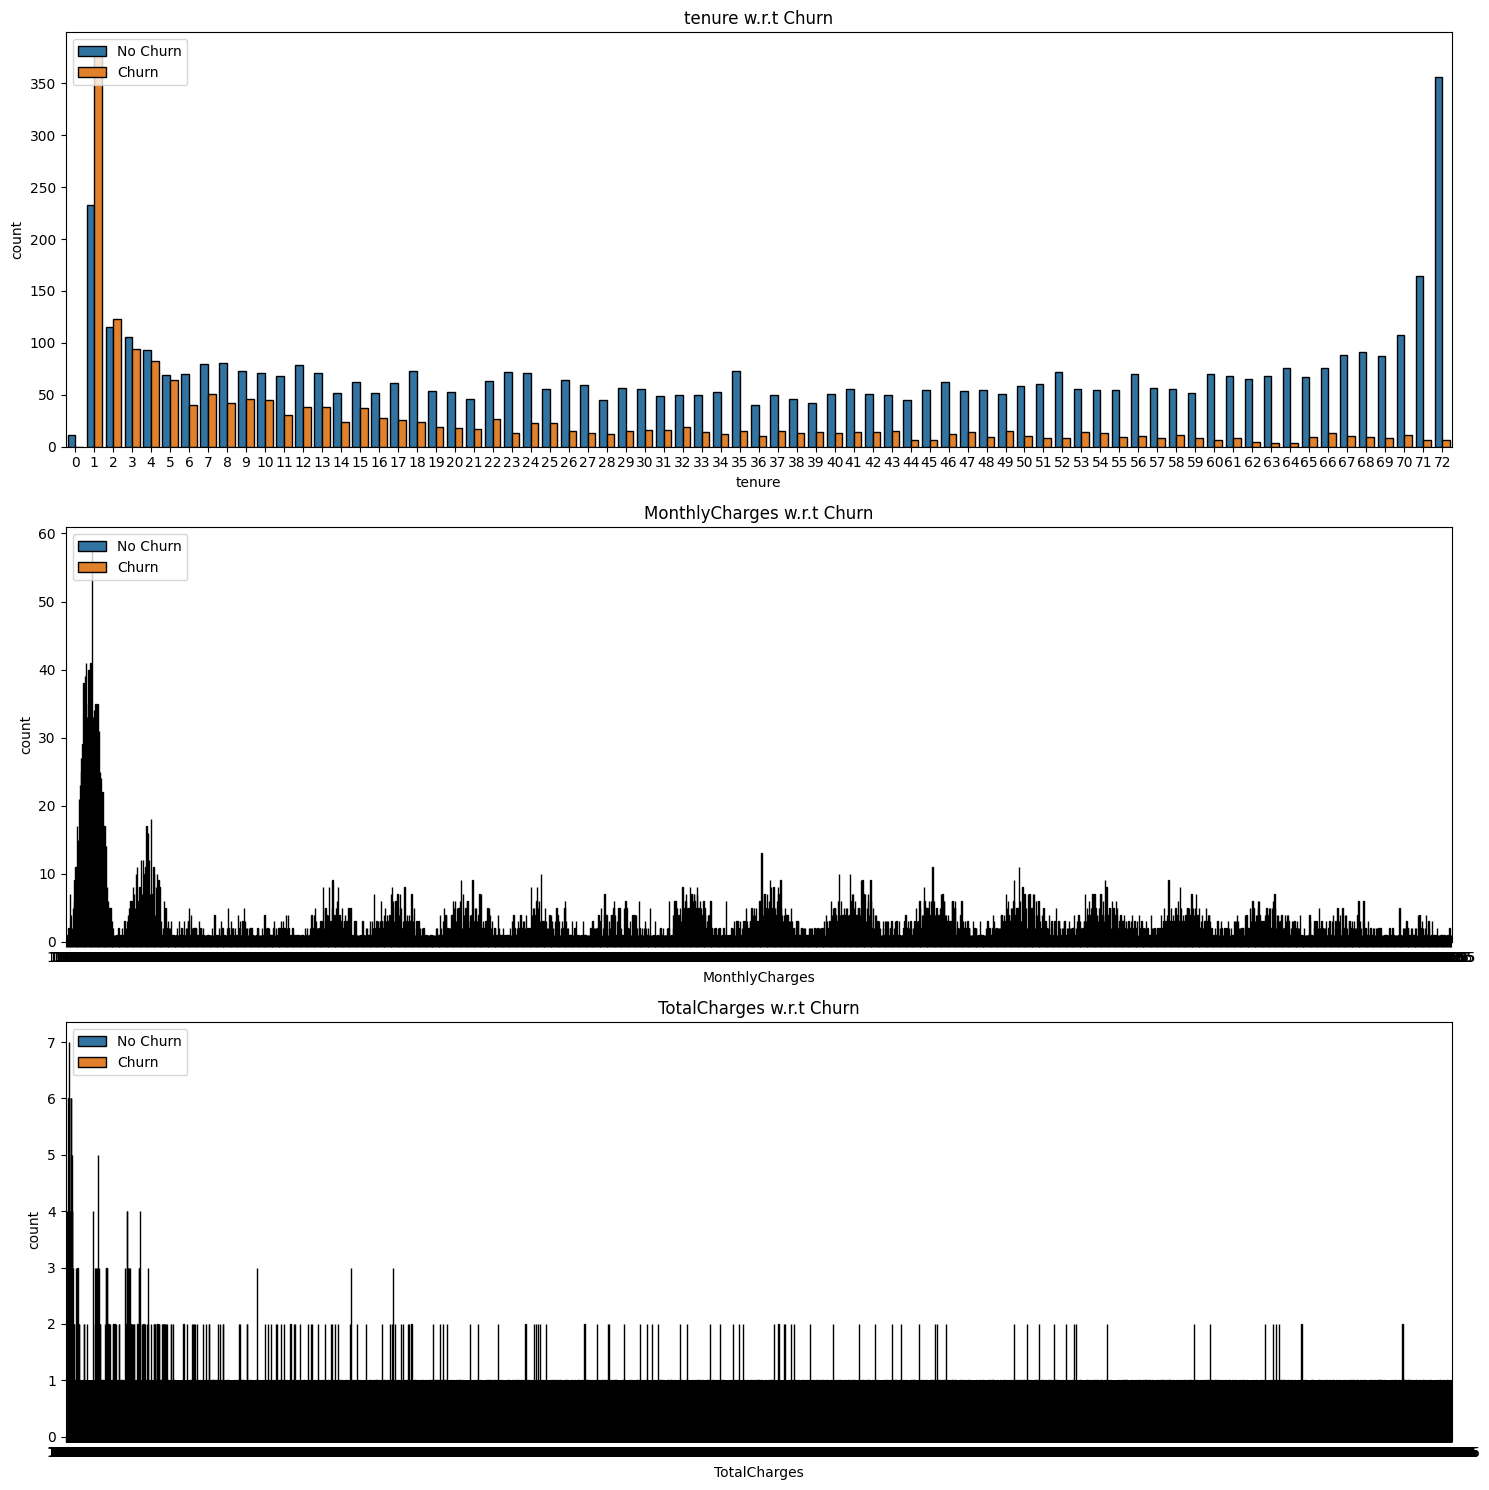

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

for i, feature in enumerate(numerical_features):
    sns.countplot(x=feature, data=df, hue="Churn", edgecolor='black', ax=ax[i])
    ax[i].legend(['No Churn', 'Churn'], loc='upper left')
    ax[i].set_title(f'{feature} w.r.t Churn')

plt.tight_layout()
plt.show()

- Considering tenure, a high number of customers have left after the 1st month. This high cancellation of services continues for about 4 - 5 months but the churn customers have reduced since the 1st month. As the tenure increases, customers dropping out decreases.
- This results in low customer churning as the tenure increases. It displays a symmetrical graph with the left side dominating with churn numbers and right side dominating with low churn numbers.
- Because of too many unique data points in MonthlyCharges & TotalCharges, it is difficult to gain any type of insight. Thus, we will scale these numerical features for understandable visualization and gaining insights purposes. This brings the varied data points to a constant value that represents a range of values.
- Here, we divide the data points of the numerical features by 5 or 500 and assign its quotient value as the representative constant for that data point. The scaling constants are decided by looking into the data & intuition.

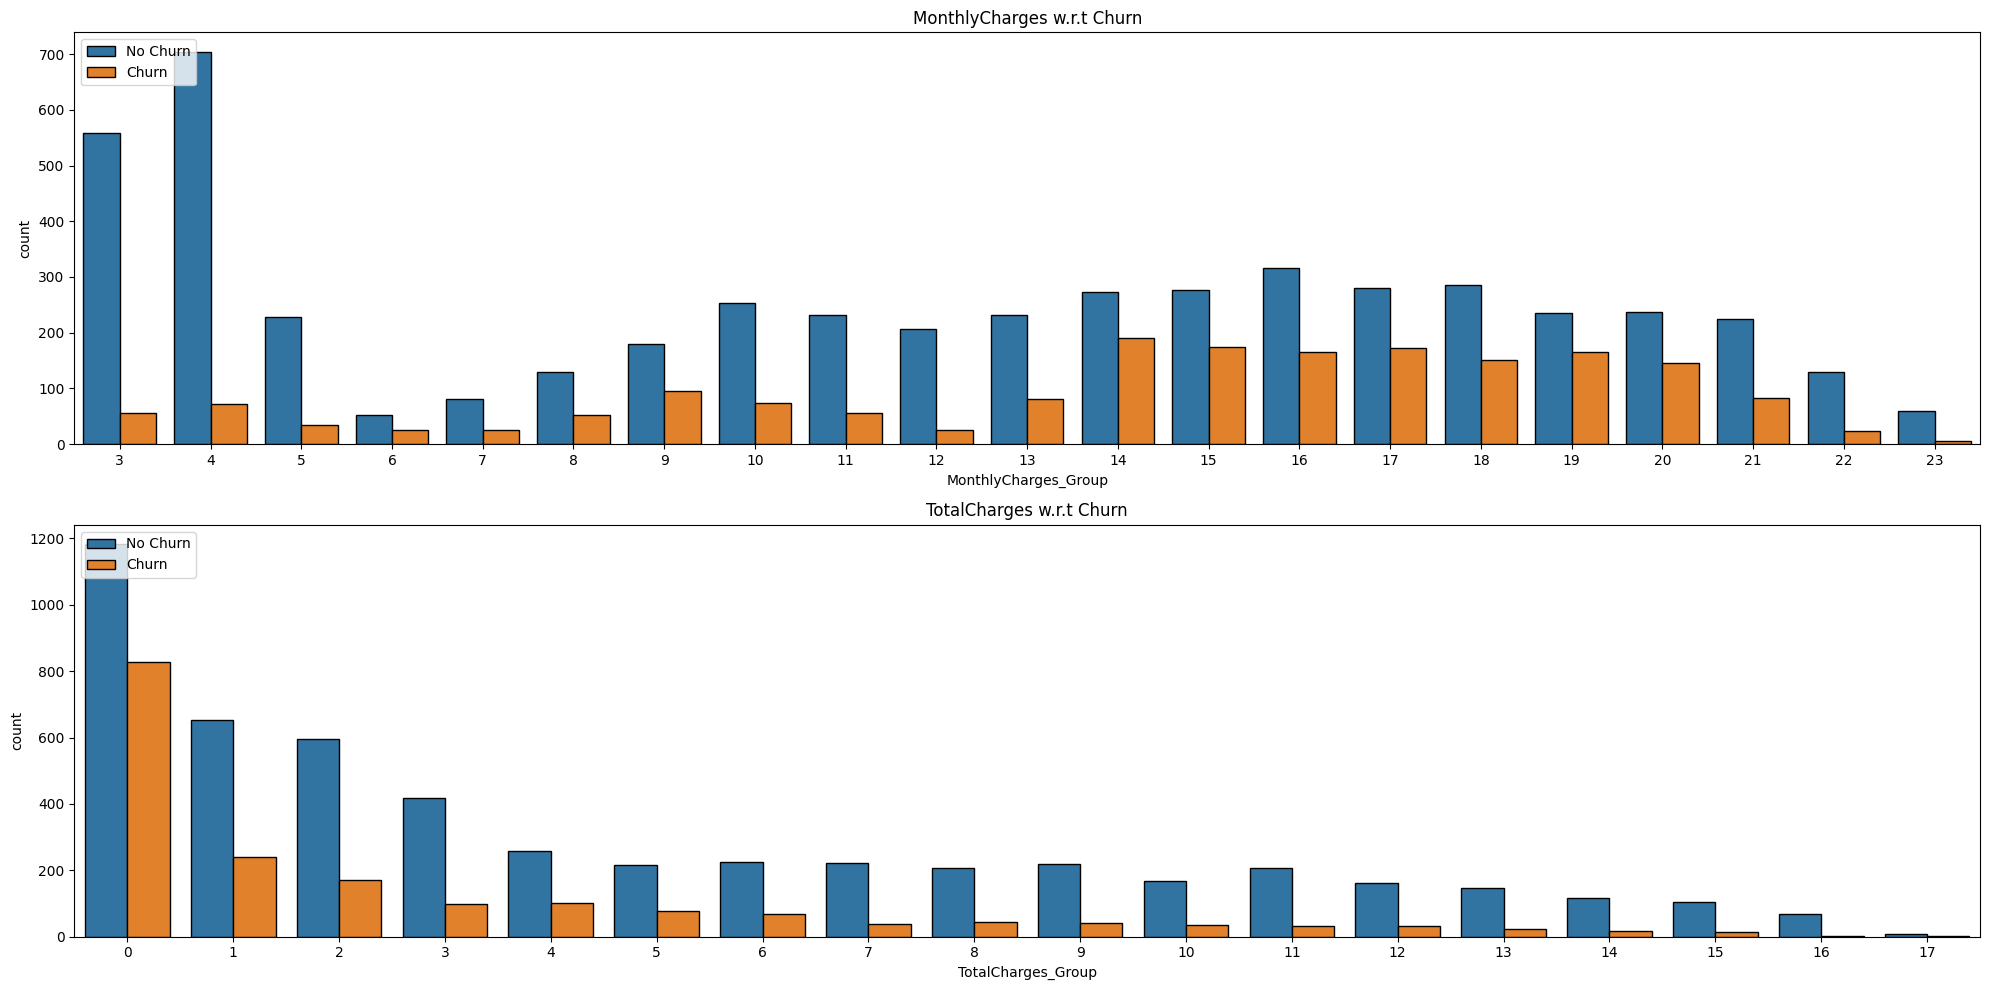

In [40]:
# NaN in 'MonthlyCharges' and 'TotalCharges' 
df['MonthlyCharges'] = df['MonthlyCharges'].fillna(0)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Group 'MonthlyCharges' and 'TotalCharges' 
df['MonthlyCharges_Group'] = [int(i / 5) for i in df['MonthlyCharges']]
df['TotalCharges_Group'] = [int(i / 500) for i in df['TotalCharges']]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
for i in range(len(numerical_features[1:])):
    sns.countplot(x=numerical_features[1 + i] + '_Group', data=df, hue="Churn", edgecolor='black', ax=ax[i])
    ax[i].legend(['No Churn', 'Churn'], loc='upper left')
    ax[i].set_title(f"{numerical_features[1 + i]} w.r.t Churn")

plt.tight_layout()
plt.show()

- For MonthlyCharges group, churn rate is high for the values between groups 14 and 21. This MonthlyCharges range of values caused the customers to switch.
- A very high number of customers opted out of the services for the TotalCharges below groups 2.

### Numerical features vs Categorical features w/ respect to Target variable (Churn):

tenure vs Group 1 : 
    
Customer Information : gender | SeniorCitizen | Partner | Dependents 

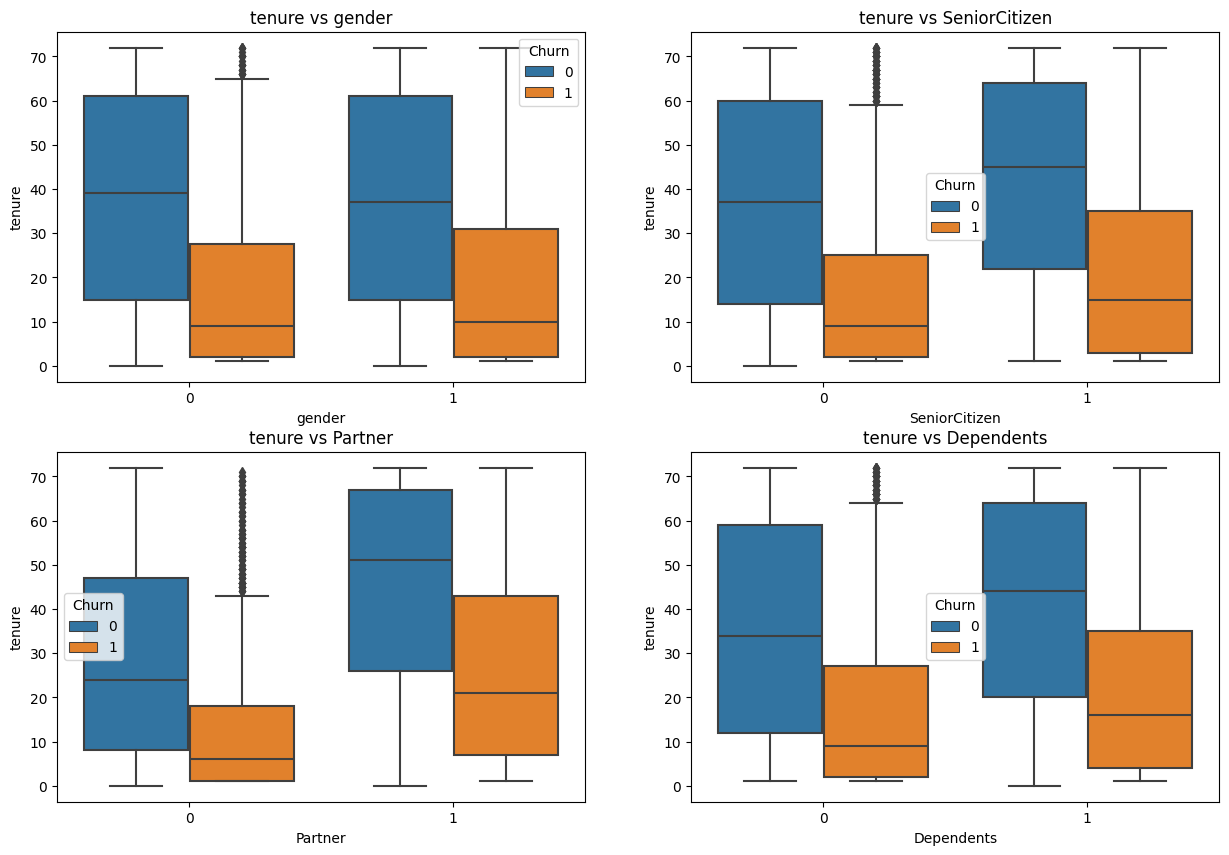

In [41]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = list1[i],y = 'tenure',data = df,hue = 'Churn');
    plt.title('tenure vs ' + list1[i]);

- Male & Female customer churn graphs are very similar.
- SeniorCitizen opted out from the services for a tenure values of 0 - 35 months. 20 - 35 months is the kind of decision making period about whether to continue or swtich for SeniorCitizen.
- Similarly, customers with partners continued with the service for a tenure of 5 - 45 months.

tenure vs Group 2: 
Services Subscribed by the Customer : 

PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies |

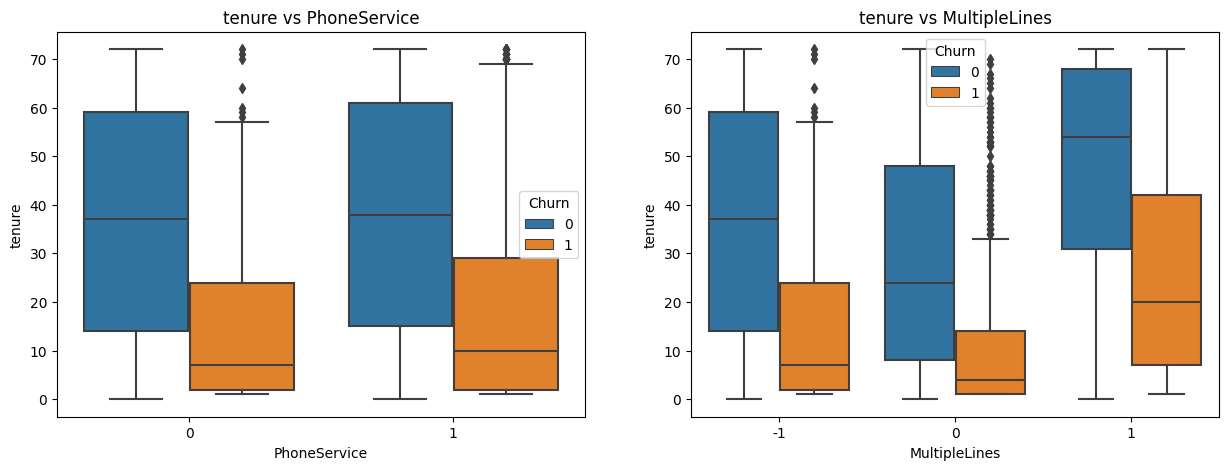

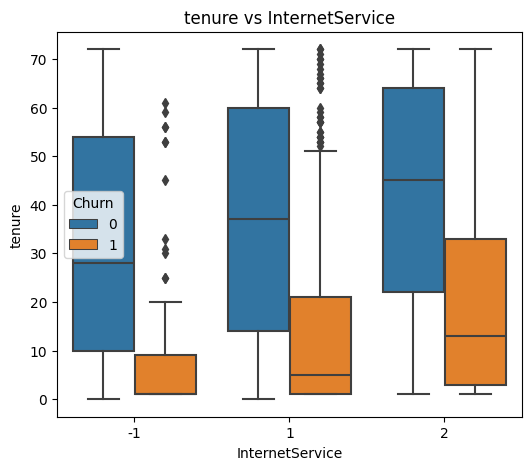

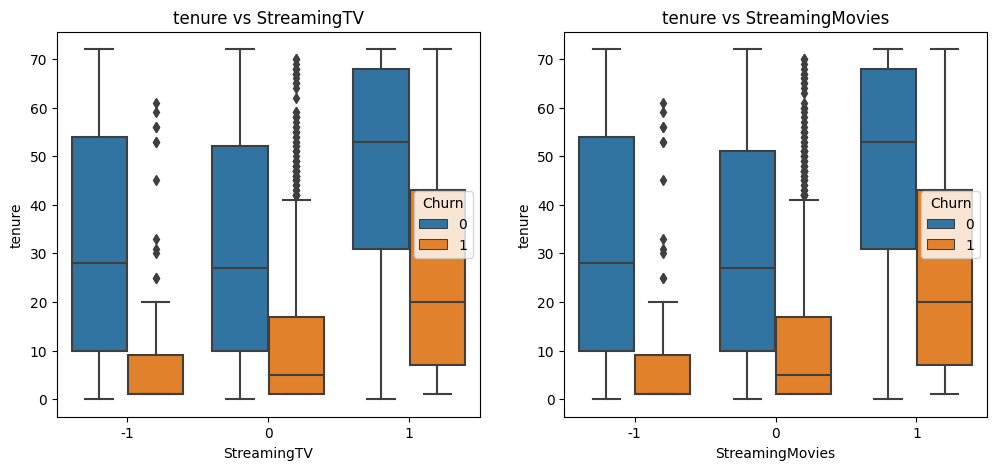

In [42]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(list2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = list2[i],y = 'tenure',data = df,hue = 'Churn');
    plt.title('tenure vs ' + list2[i]);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = list2[2],y = 'tenure',data = df,hue = 'Churn');
plt.title('tenure vs ' + list2[2]);
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(list2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = list2[i + 3],y = 'tenure',data = df,hue = 'Churn');
    plt.title('tenure vs ' + list2[i + 3]);

- Presence of MutipleLines pushes the median MonthlyCharges irrespective if the customers opt out of the services or not.
- For the graph of tenure vs PhoneService, availability of PhoneService or not display a mirroring visuals. Customers were probably not heavy phone (call - message) users.
- For InternetService, customers seem to be very skeptical about the usage of Optic Fibre cables as the churning lasted for about 30 - 35 months before either carrying it forward or switching to a new one!
- Similary for StreamingTV & StreamingMovies, a churn tenure period of about 10 - 40 months can be observed!


tenure vs Group 2: Services Subscribed by the Customer : 
        
OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport |

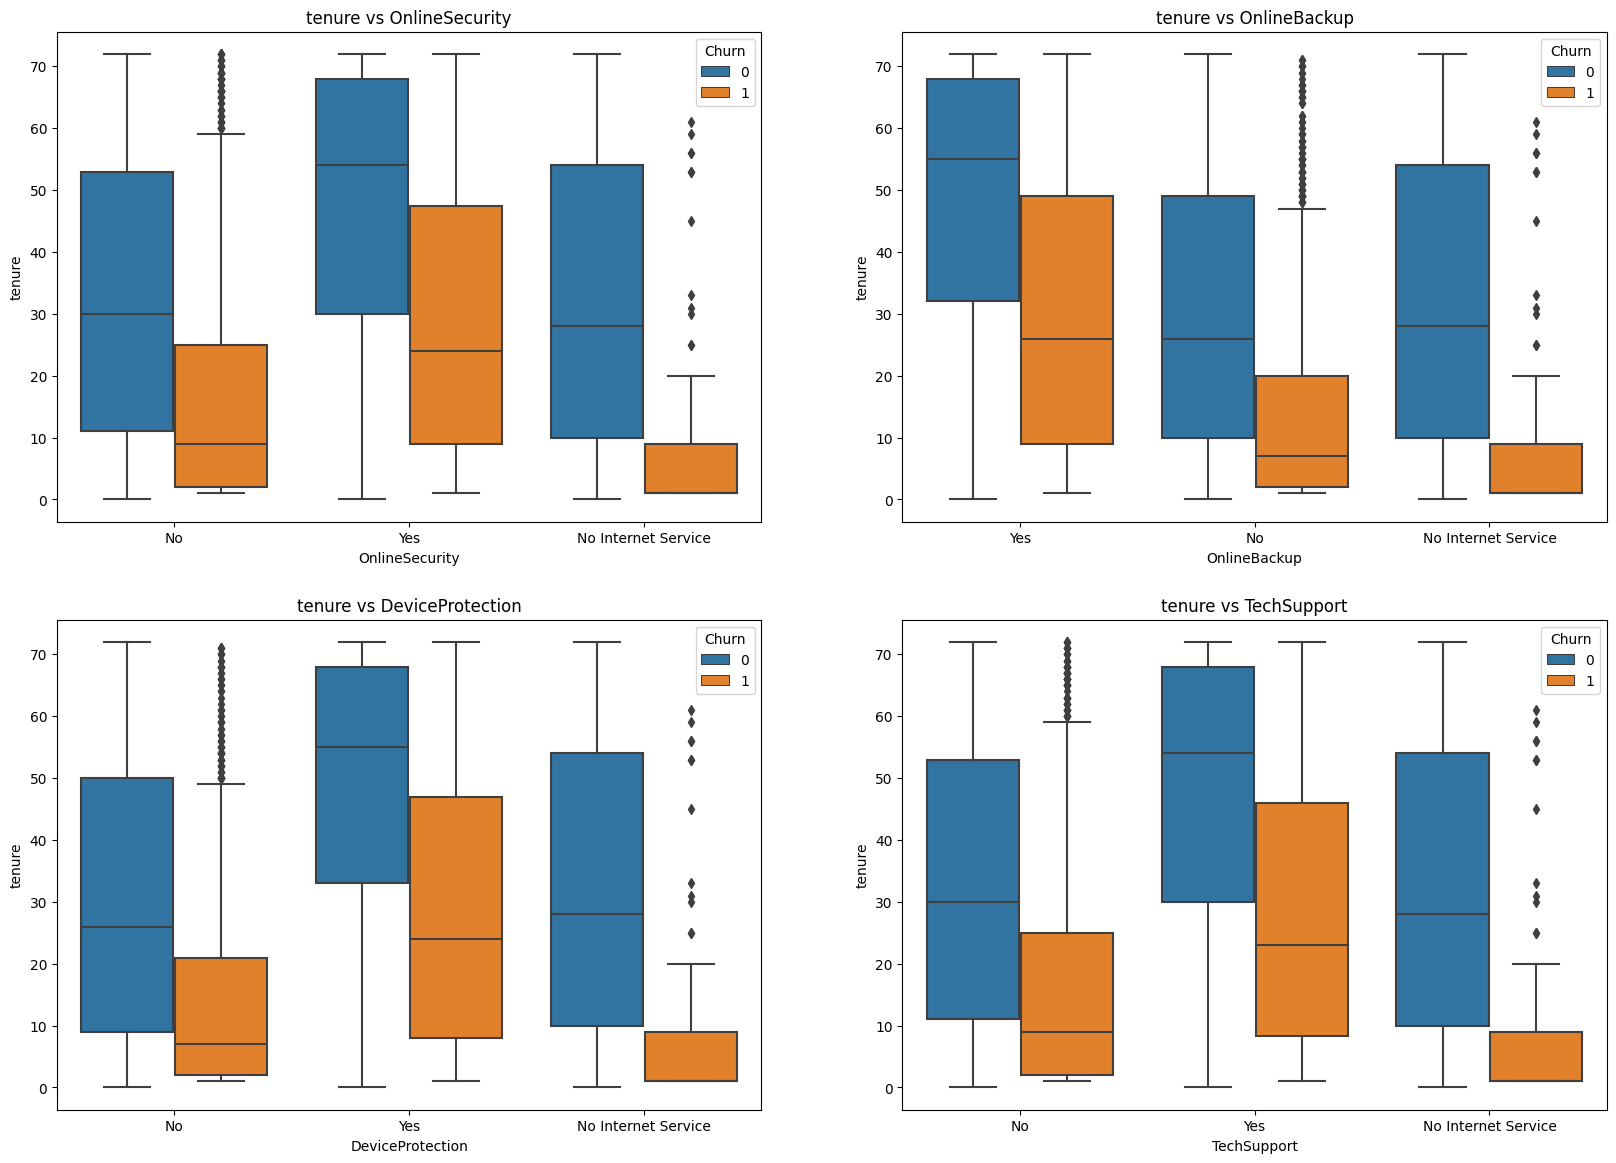

In [43]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(list2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = list2[i - 4],y = 'tenure',data = df,hue = 'Churn');
    plt.title('tenure vs ' + list2[i-4]);

- For OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport, median churn tenure value is of 25 months. The highest value of this churn tenure is of around 45 months.
- 30 - 35 month period is where the customers take a call about whether to continue with the current services 


tenure vs Group 3 : 
    
Contract | PaperlessBilling | PaymentMethod |

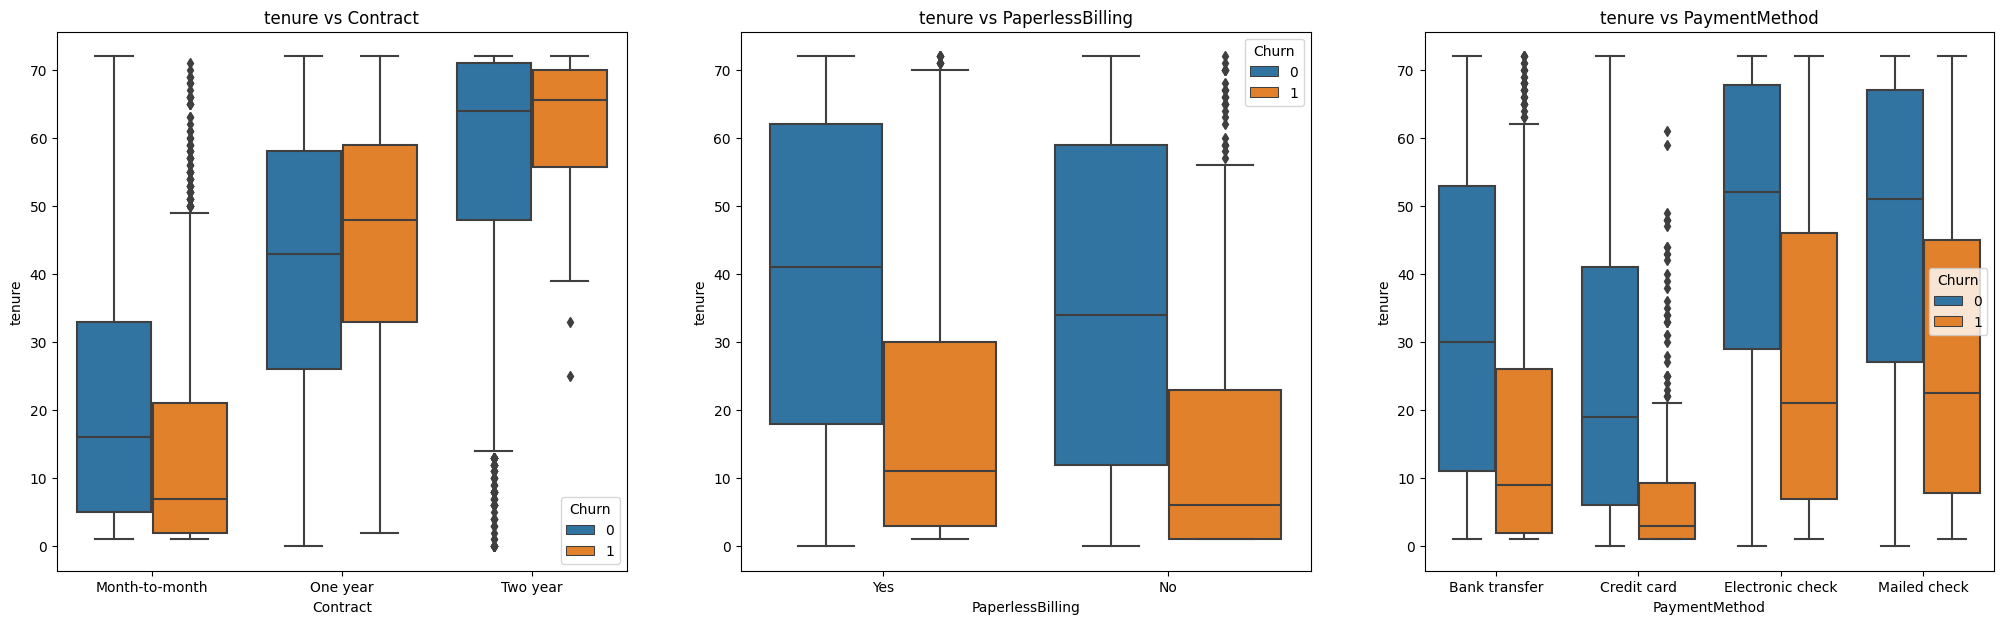

In [44]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
for i in range(len(list3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = list3[i],y = 'tenure',data = df,hue = 'Churn');
    plt.title('tenure vs ' + list3[i]);


- When customers sign One year and Two year contracts for the services, they seem to continue with the services for about 25 and 45 months respectively. However, they start questioning the services and think about switching from the 35 month and 55 month mark.
- Irrespective of the PaperlessBilling, customers think of switching right from the 1st month.
- When it comes to PaymentMethod, median churn tenure of Bank Transfer (automatic) & Credit Card (automatic), above 20 months, is nearly double than that of Electronic check & Mailed check, around 10 months & around 5 months

MonthlyCharges vs Group 1 : 

Customer Information : 
    
gender | SeniorCitizen | Partner | Dependents |

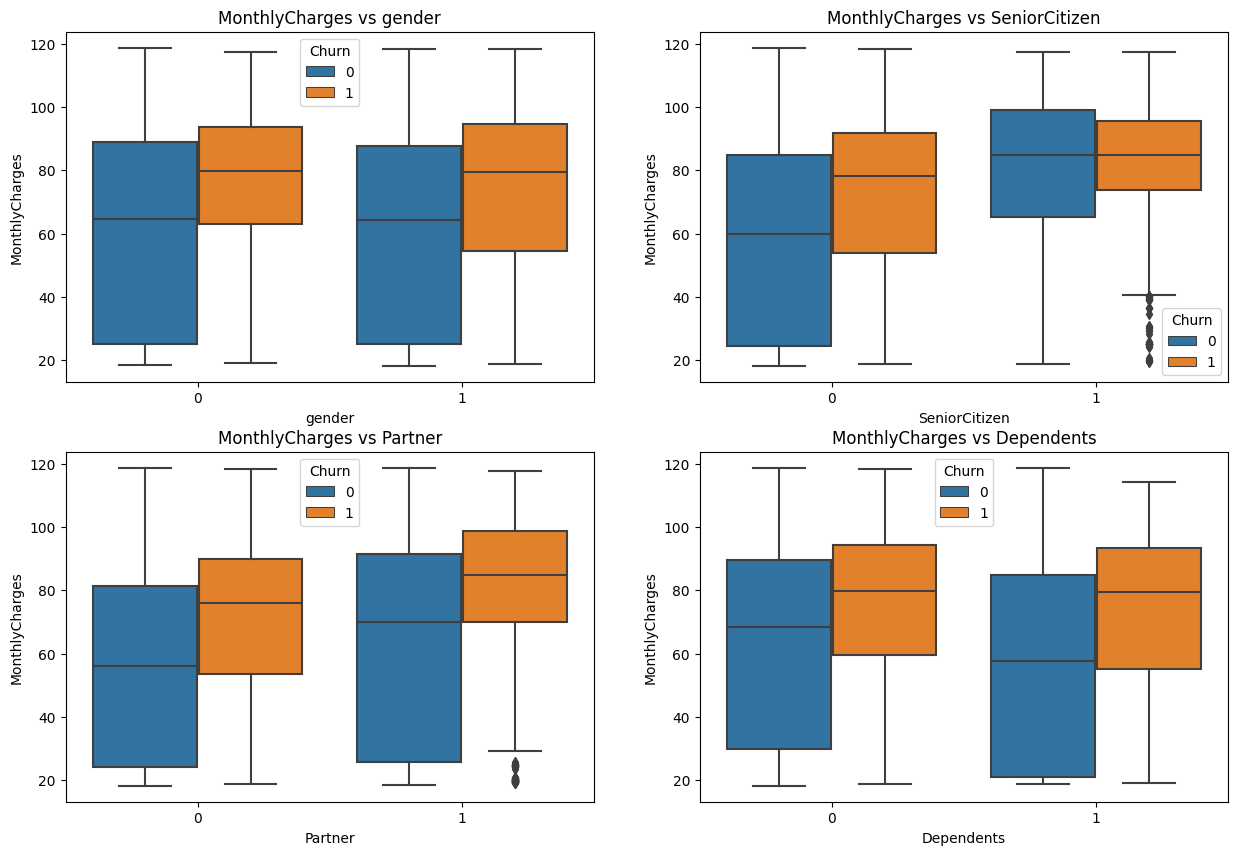

In [45]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = list1[i],y = 'MonthlyCharges',data = df,hue = 'Churn'); 
    plt.title('MonthlyCharges vs ' + list1[i]);

- For all the features mentioned above, the median value of the not-churn customers is very close to the lower limit of the churn customers.
- Male & Female customers have the same median MonthlyCharges of around 60. For SeniorCitizen, this value is pushed to 80.
- Customers living with Partner have a higher lower limit of churning, MonthlyCharges of 70, than those living alone, MonthlyCharges of just below 60

MonthlyCharges vs Group 2: 

Services Subscribed by the Customer : 

PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies |

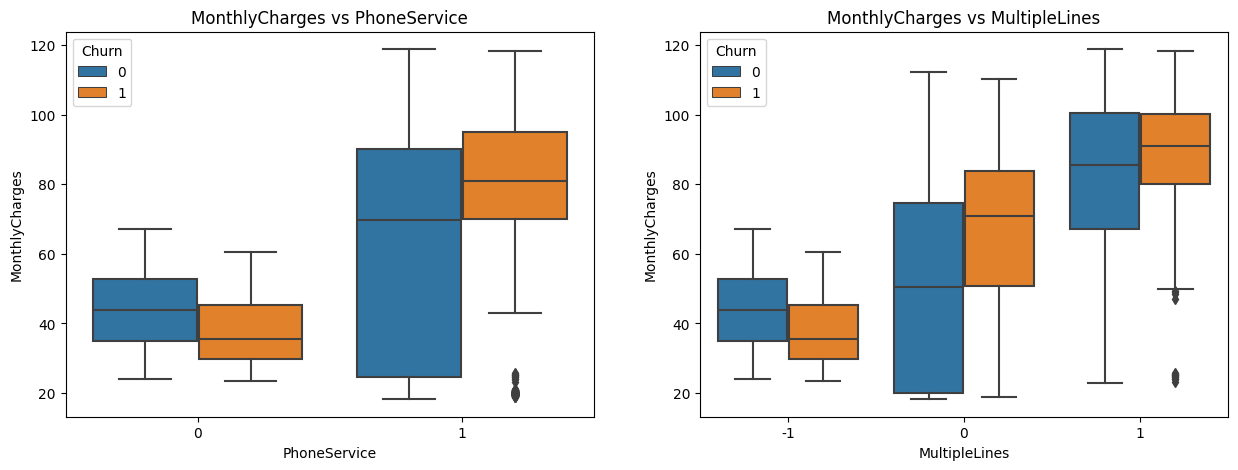

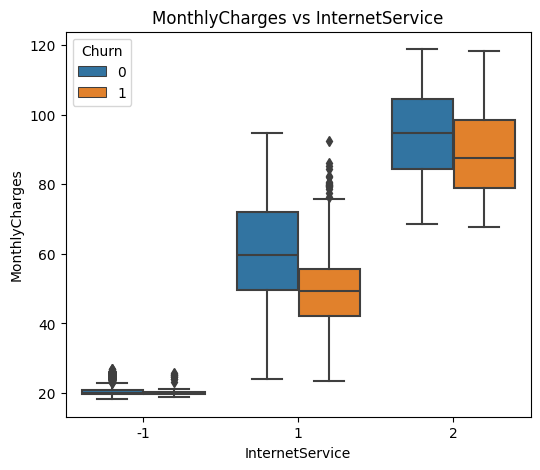

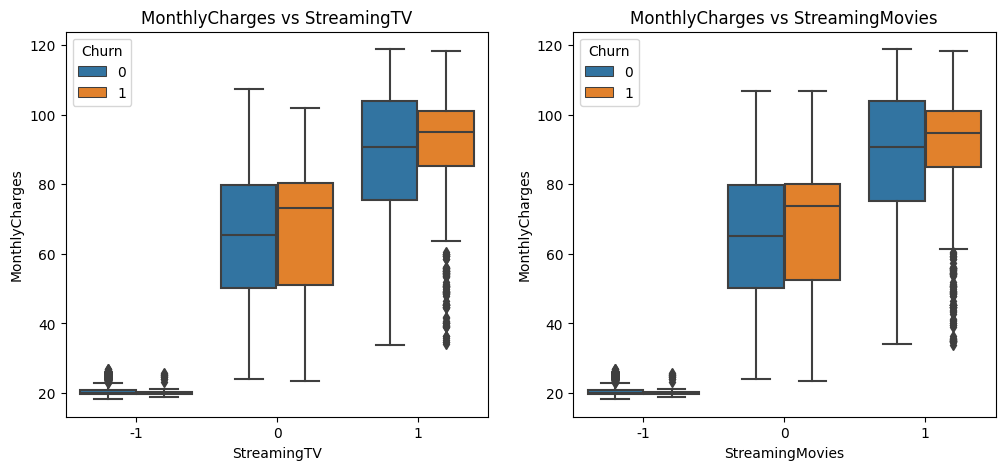

In [46]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(list2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = list2[i],y = 'MonthlyCharges',data = df,hue = 'Churn');
    plt.title('MonthlyCharges vs ' + list2[i]);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = list2[2],y = 'MonthlyCharges',data = df,hue = 'Churn');
plt.title('MonthlyCharges vs ' + list2[2]);
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(list2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = list2[i + 3],y = 'MonthlyCharges',data = df,hue = 'Churn');
    plt.title('MonthlyCharges vs ' + list2[i + 3]);

- MonthlyCharges of Fiber Optic cables is very high. Thus, it might be the reason for such high churn of customers.
- Similarly, MonthlyCharges of StreamingTV & StreamingMovies is quite high.
- Range of MonthlyCharges for PhoneService is from 25 - 85 but customers think of unsubscribing from 75 value of MonthlyCharges.

MonthlyCharges vs Group 2: 
    
Services Subscribed by the Customer : 
    
OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport 

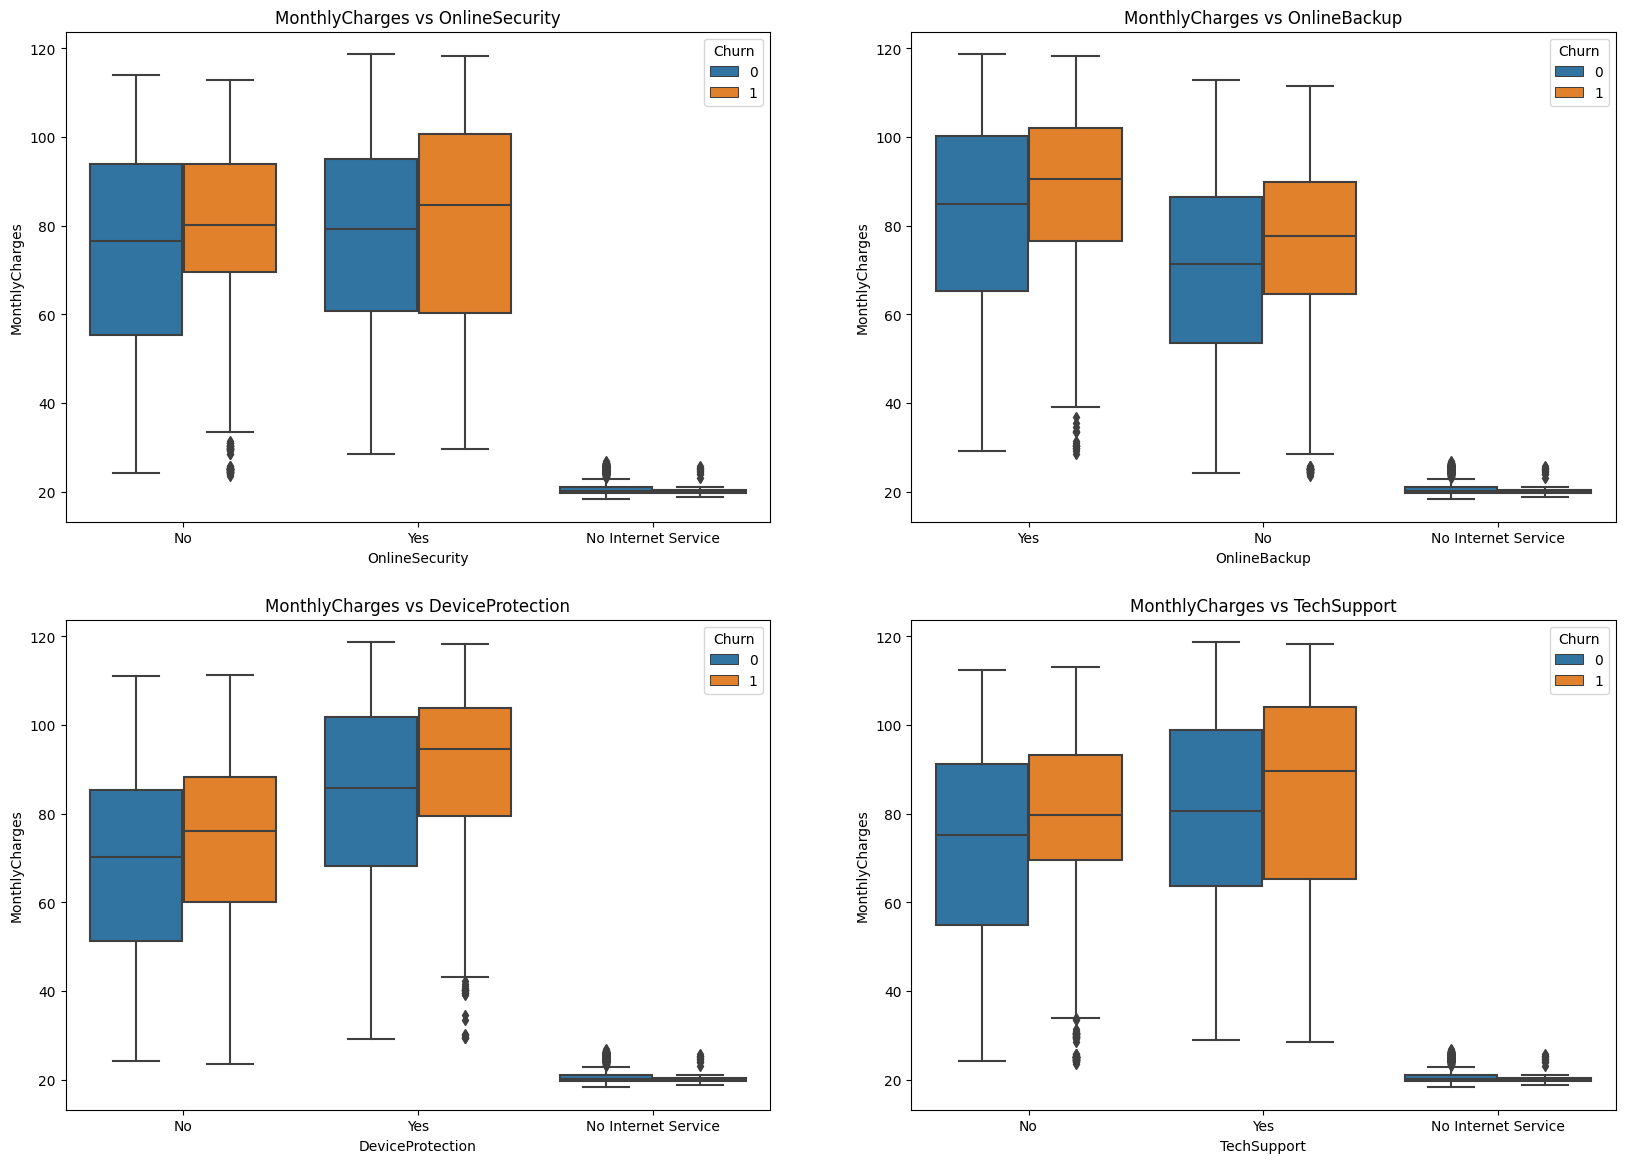

In [47]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(list2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = list2[i - 4],y = 'MonthlyCharges',data = df,hue = 'Churn');
    plt.title('MonthlyCharges vs ' + list2[i-4]);

- For OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport, range of values is from around 50 to 100.
- Customers who subscribe who to these services, probably don't think about cancelling the subscription due to MonthlyCharges as the range of values of customers who unsubscribe & continue is near about the same

MonthlyCharges vs Group 3 : 
    
Contract | PaperlessBilling | PaymentMethod |

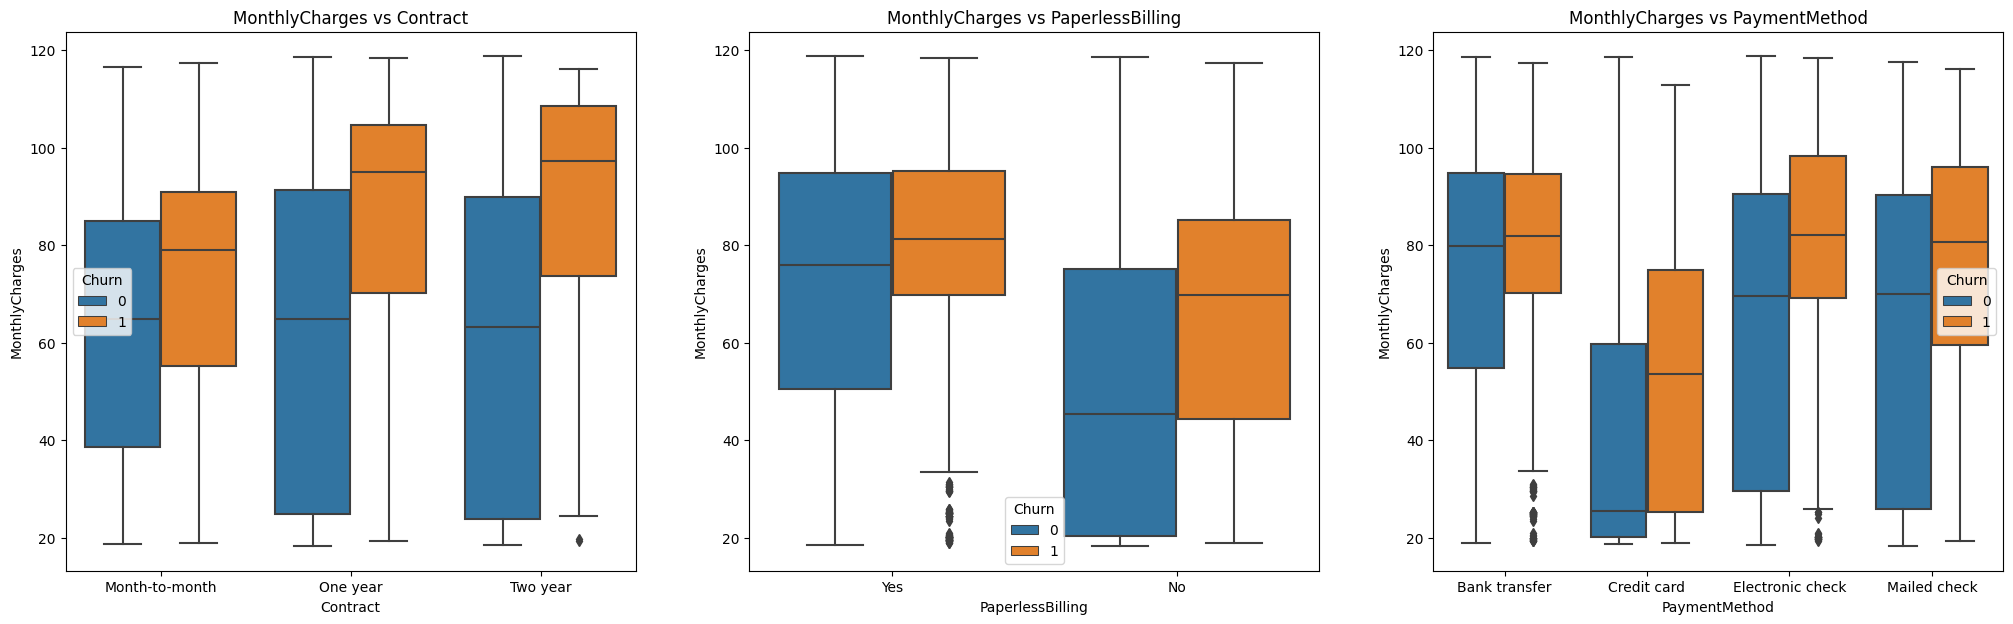

In [48]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

for i in range(len(list3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = list3[i],y = 'MonthlyCharges',data = df,hue = 'Churn');
    title = 'MonthlyCharges vs ' + list3[i]
    plt.title(title);

- Lower limit of the MonthlyCharges is higher for Month-to-Month contract than One year & Two year contracts. However the lower limit of the customers who discontinue the services is lower for Month-to-Month contract.
- Lower limit of the Electronic check is very high and it can be a huge factor due to which customers resent using it! Whereas Mailed check has the lowest starting values of customers who left and continued.

TotalCharges vs Categorical Features :
    
TotalCharges vs Group 1 : 
    
Customer Information : gender | SeniorCitizen | Partner | Dependents |

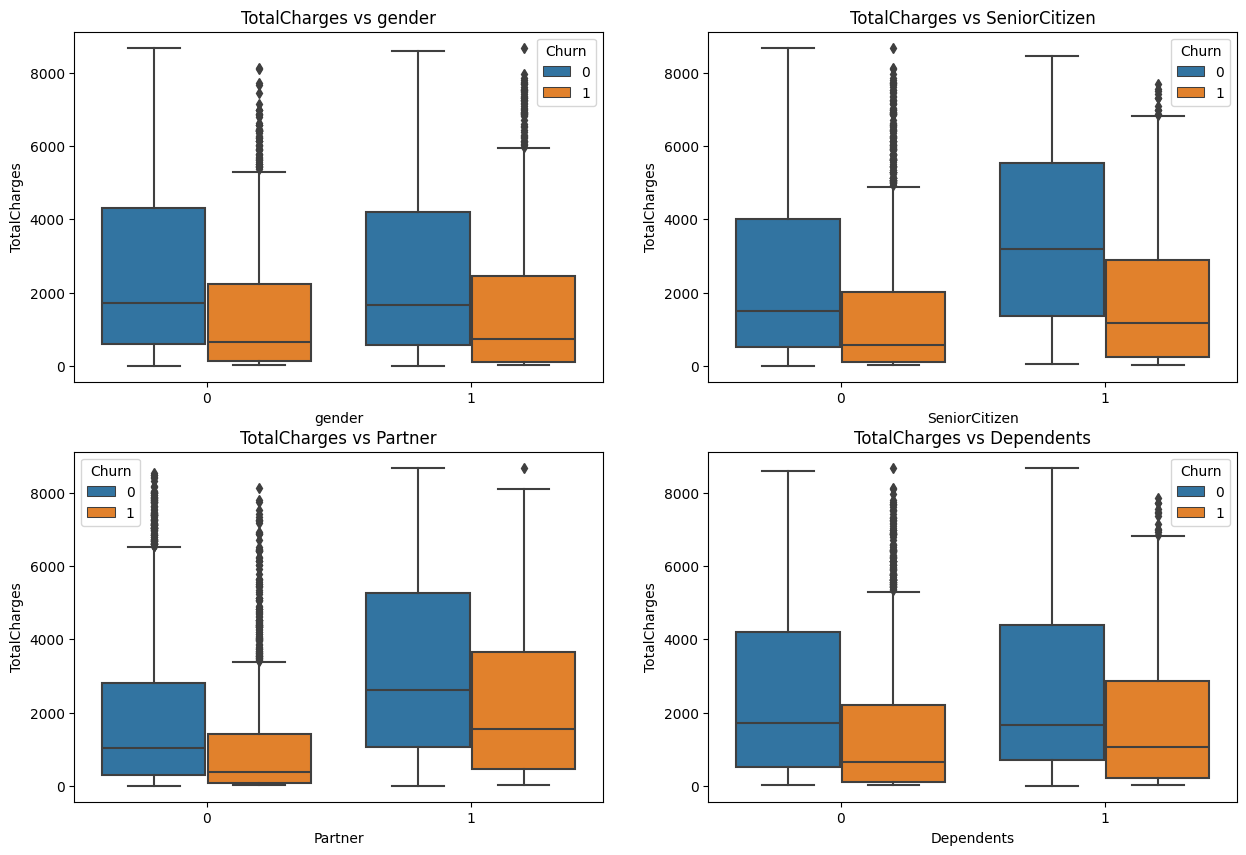

In [49]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = list1[i],y = 'TotalCharges',data = df,hue = 'Churn');
    plt.title('TotalCharges vs ' + list1[i]);

- TotalCharges for male & female customers is quite equal. SeniorCitizen that continued with the services have a higher starting and closing values of TotalCharges.
- Customers housing with their Partner have a higher median value of TotalCharges as compared to those living alone

TotalCharges vs Group 2: 

Services Subscribed by the Customer : 

PhoneService | MultipleLines | InternetService | StreamingTV | StreamingMovies |

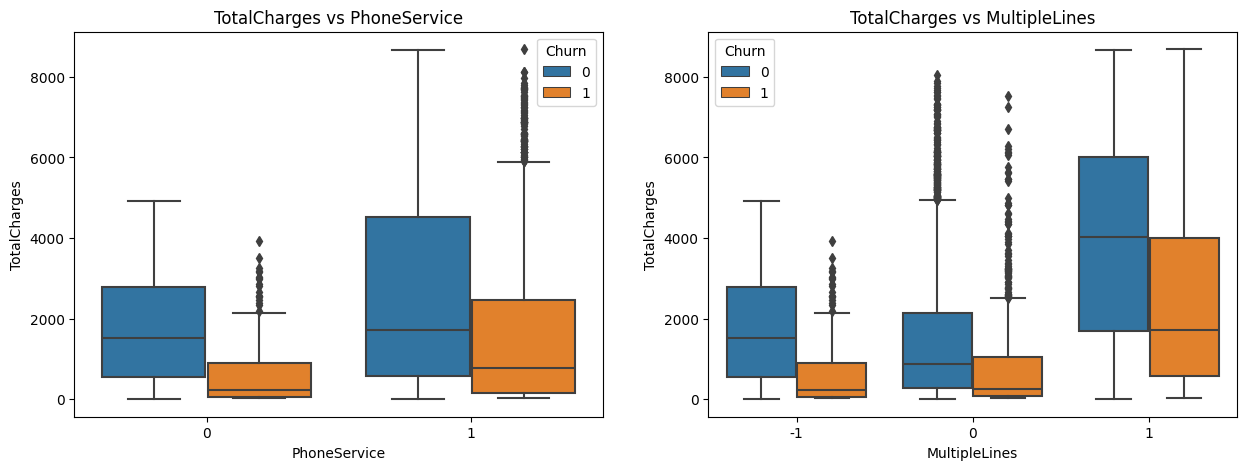

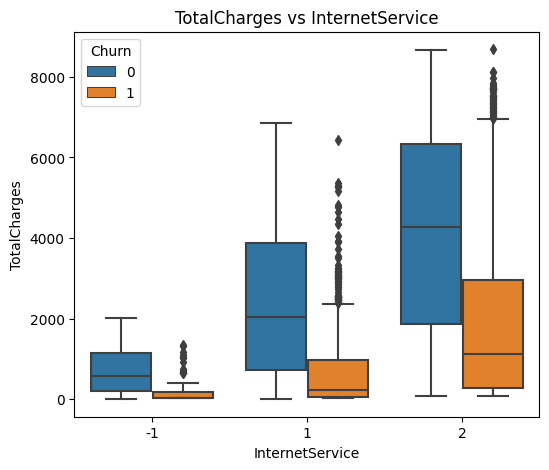

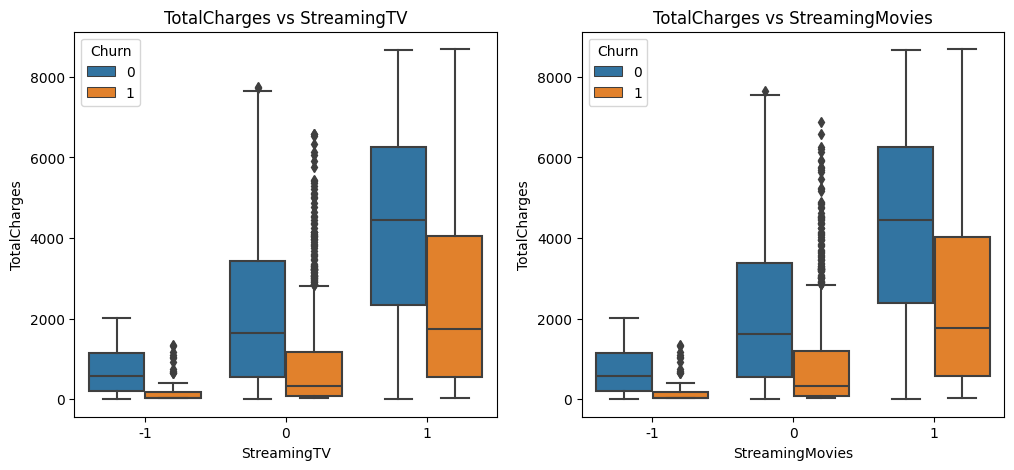

In [50]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(list2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = list2[i],y = 'TotalCharges',data = df2,hue = 'Churn');
    plt.title('TotalCharges vs ' + list2[i]);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = list2[2],y = 'TotalCharges',data = df2,hue = 'Churn');
plt.title('TotalCharges vs ' + list2[2]);
    
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(list2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = list2[i + 3],y = 'TotalCharges',data = df2,hue = 'Churn');
    plt.title('TotalCharges vs ' + list2[i + 3]);

- TotalCharges of PhoneService range from 0 - 4000. However, customers start getting 2nd thoughts about PhoneService due to TotalCharges from around 1000.
- Similarly, customers start to hesitate to pay around 2000 for MultipleLines. However, some customers seem to be desperate for MultipleLines as they paid a value of around 6000 
- When it comes to paying for Fiber Optic cables, customers test out the products by paying around 2000
- Similar to Fiber Optic, StreamingTV & StreamingMovies, customers that continue with the services pay from 3000 - 6000.

TotalCharges vs Group 2: 

Services Subscribed by the Customer : 

OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport |

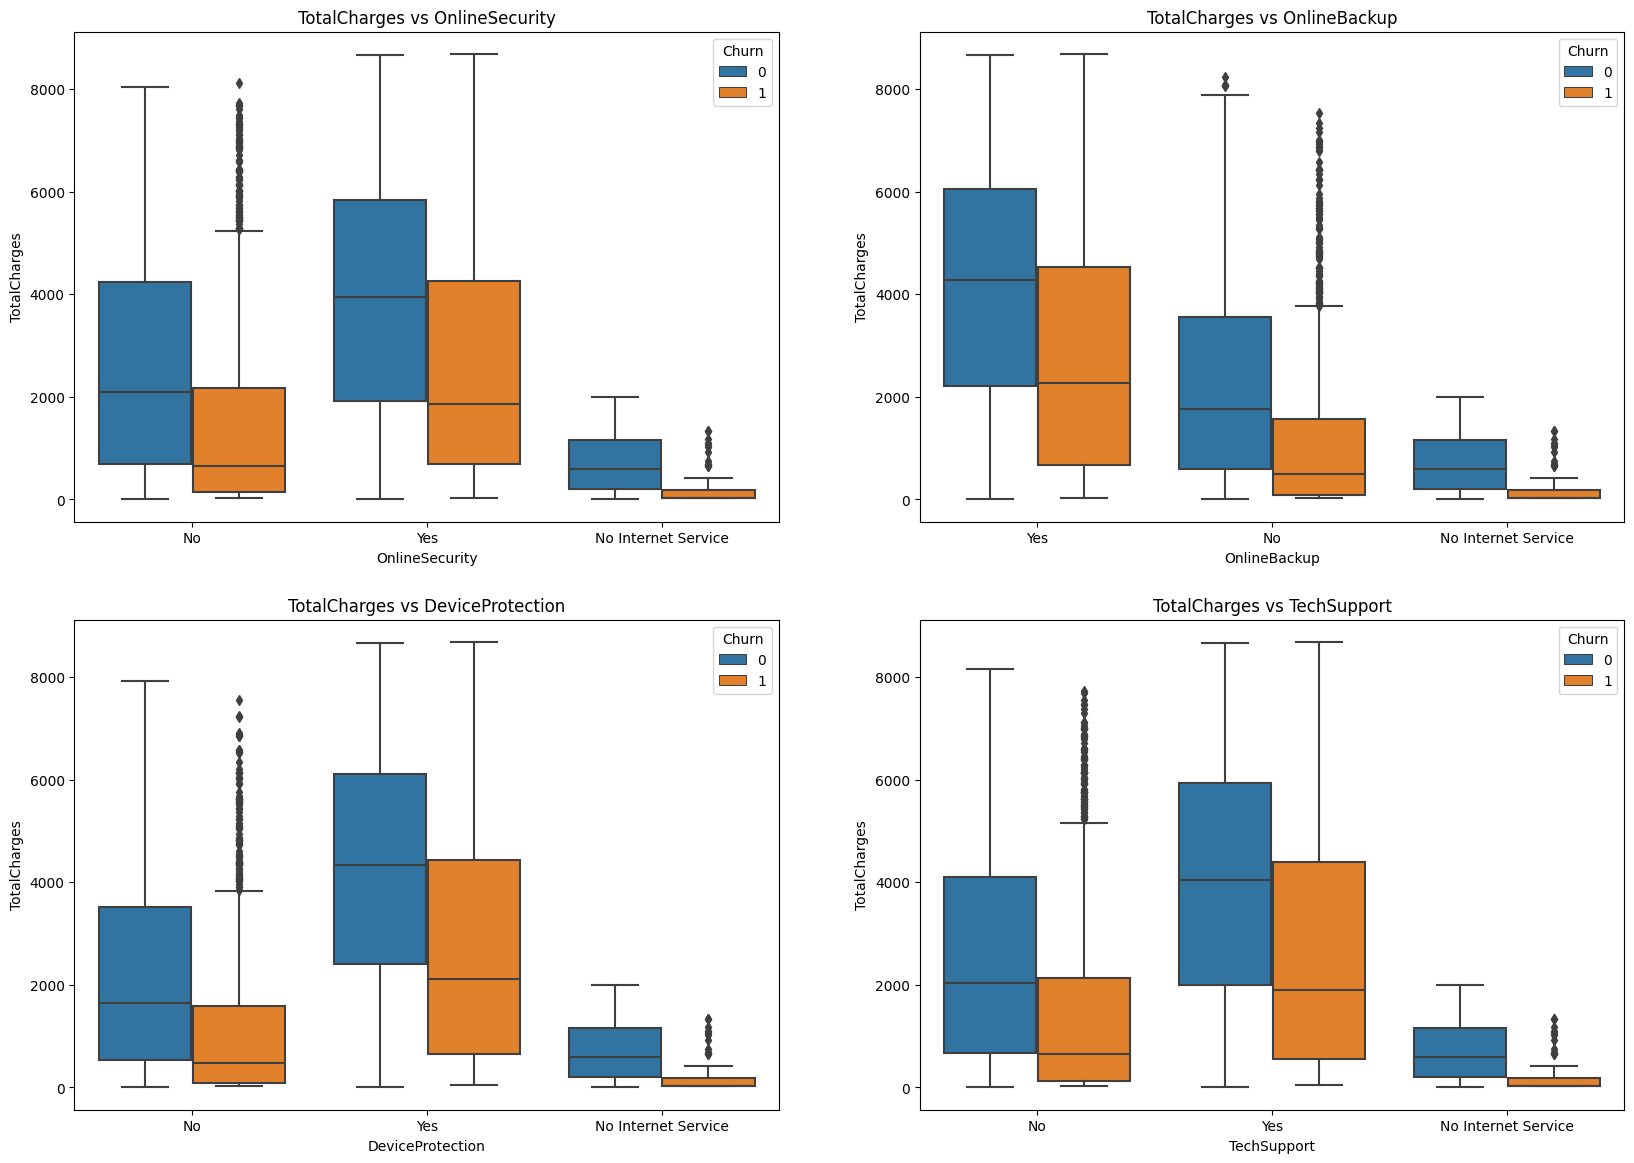

In [51]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(list2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = list2[i - 4],y = 'TotalCharges',data = df,hue = 'Churn');
    plt.title('TotalCharges vs ' + list2[i-4]);

- Customers become skeptical about paying for them around the 2000 mark. This median value of churn customers is very close to the lower limit of the customers that carry on with this service.
- Customers that do not churn out are ready to pay from 2000 - 6000 of TotalCharges.


TotalCharges vs Group 3 : 
    
Contract | PaperlessBilling | PaymentMethod |

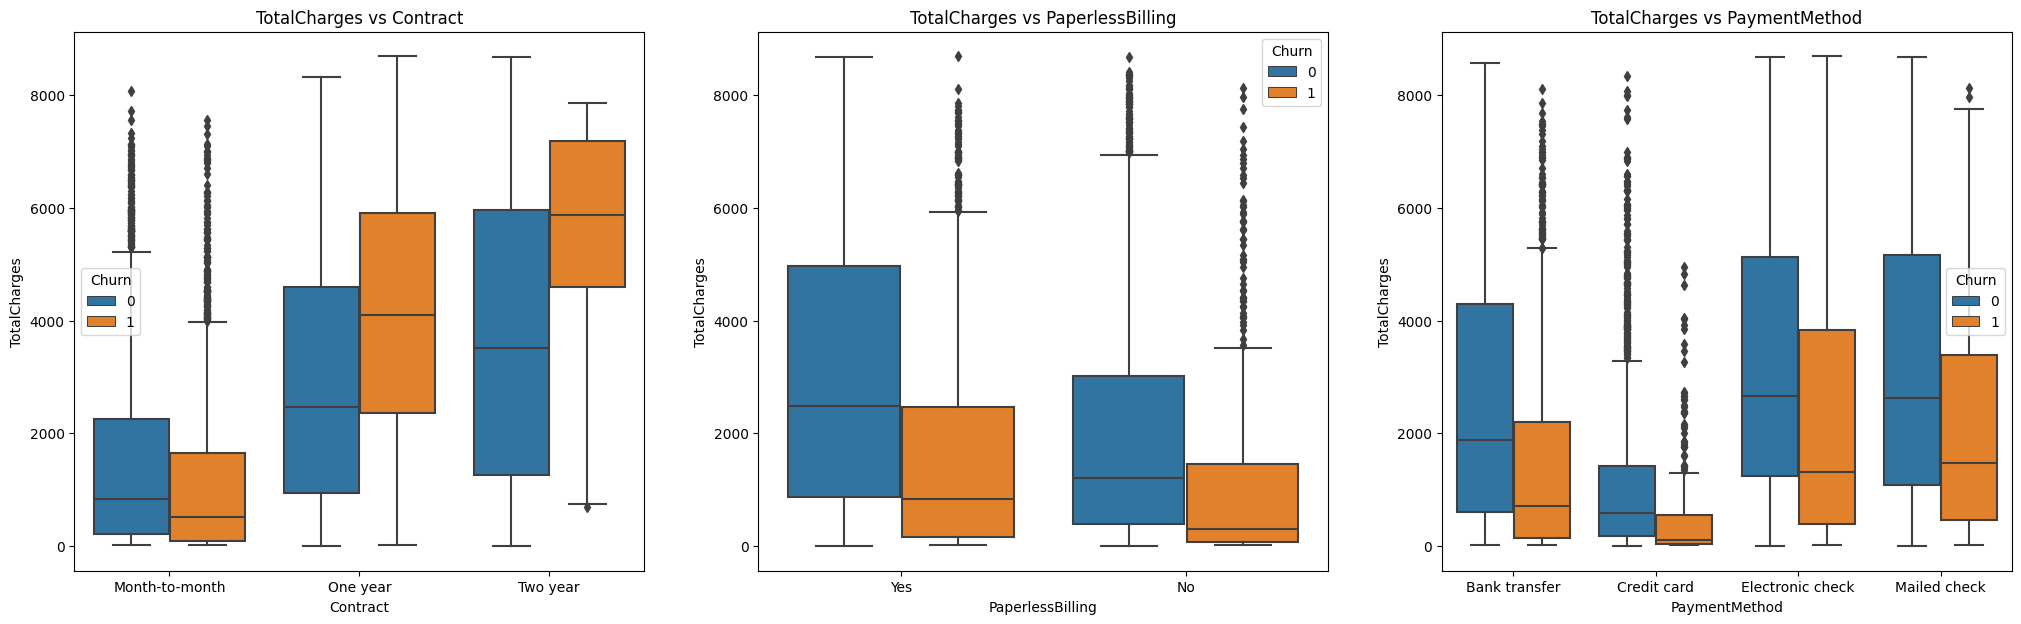

In [52]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

for i in range(len(list3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = list3[i],y = 'TotalCharges',data = df,hue = 'Churn');
    plt.title('TotalCharges vs ' + list3[i]);

- Median values of customers that decide to opt out from the services that have One year & Two year contracts is high at around 4000 & 6000. Some of the customers with Two year contracts even paid around 7000.
- For PaymentMethod, customers are skeptical to pay using Electronic check for a shorter range of 0 - 2000 whereas for Bank transfer (automatic) & Credit Card (automatic) this range is around 0 - 4000.

## Numerical features vs Numerical features w/ respect to Target variable (Churn) :

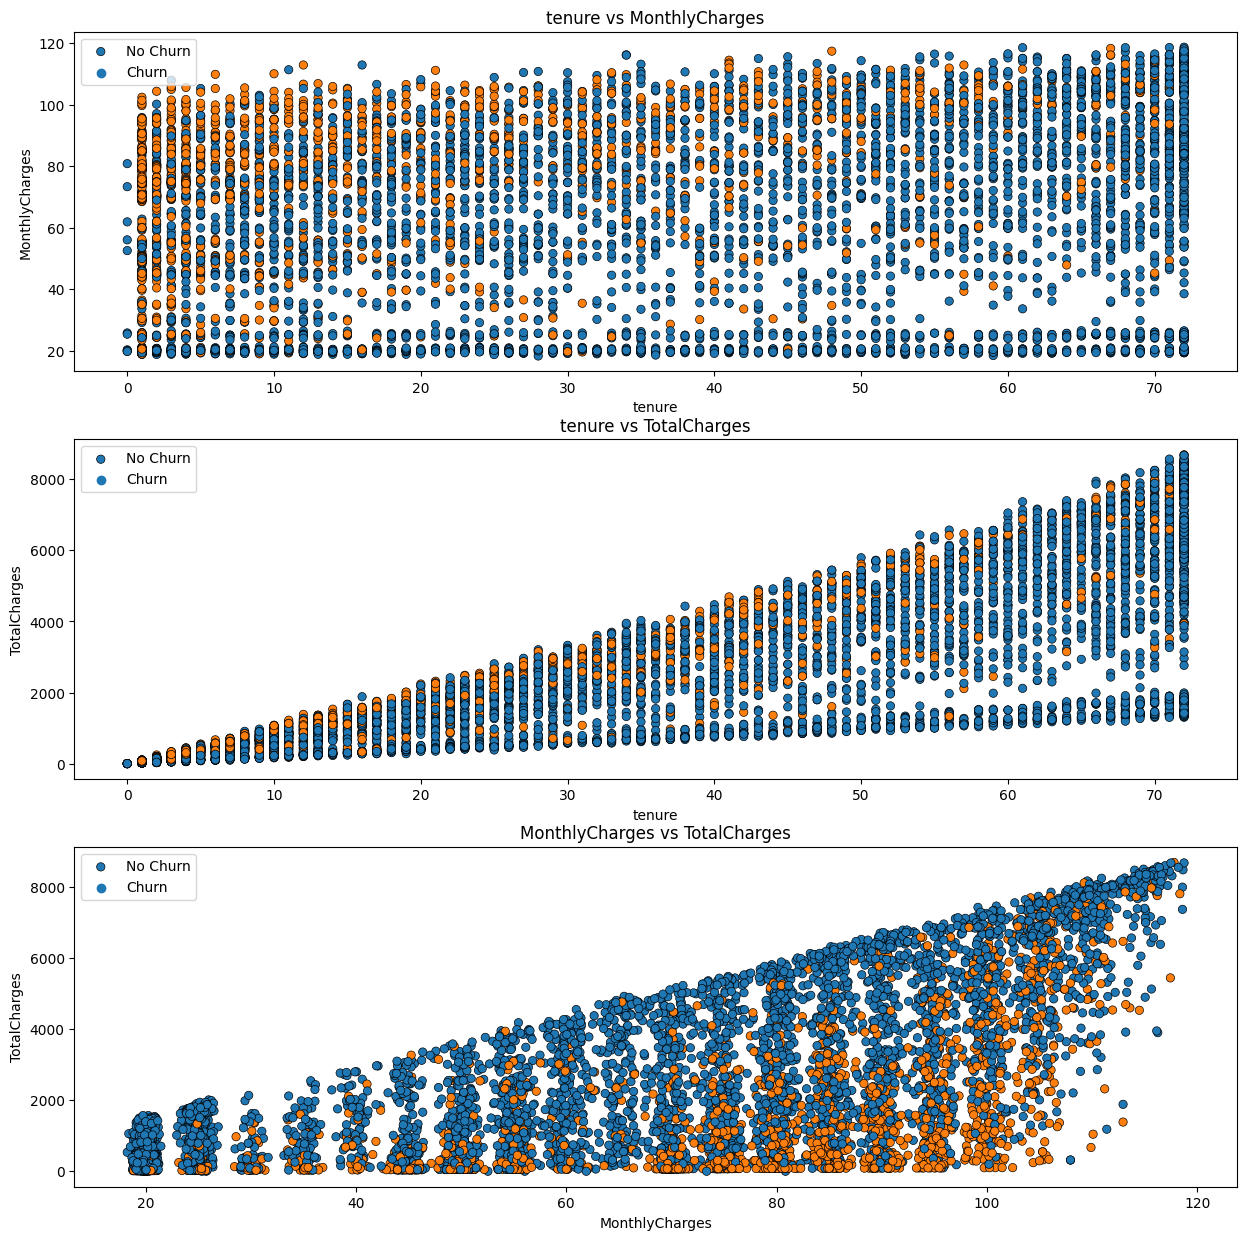

In [53]:
a = 0
fig,ax = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))
for i in range(len(numerical_features)):
    for j in range(len(numerical_features)):
        if i != j and j > i:
            a += 1
            plt.subplot(3,1,a)
            sns.scatterplot(x = numerical_features[i],y = numerical_features[j],data = df,hue = 'Churn',edgecolor = 'black');
            plt.legend(['No Churn','Churn'],loc = 'upper left',)
            title = numerical_features[i] + ' vs ' + numerical_features[j]
            plt.title(title)

- For tenure of 0 - 20 months period, churning of customers quite at any MonthlyCharges values. For a tenure period from 20 - 60 months, customers at the top end of the MonthlyCharges values, 70 - 120, start to drop out from the services.
- For TotalCharges vs tenure, as tenure increases, TotalCharges increase as well! Customers opting out from their plans are the ones who are charged the highest of their tenure period alongwith a few customers whose Total Charges rank in the middle!
- Customers seemed to have decided to cancel their subscriptions when the MonthlyCharges reach 70 and above.

# Summary of EDA

Order / Values of features for customer churn cases :

- Categorical Features (Order) :
- gender : Male = Female
- SeniorCitizen : No SeniorCitizen > SeniorCitizen
- Partner : No Partner > Partner
- Dependents : No Dependent > Dependent
- PhoneService : PhoneService > No PhoneService
- MultipleLines : MultipleLines > No MultipleLines > No PhoneService
- InternetService : Fiber Optic > DSL > No InternetService
- OnlineSecurity : Absent > Present > No InternetService
- OnlineBackup : Absent > Present > No InternetService
- DeviceProtection : Absent > Present > No InternetService
- TechSupport : Absent > Present > No InternetService
- StreamingTV : Absent > Present > No InternetService
- StreamingMovies : Absent > Present > No InternetService
- Contract : Month-to-Month > One year > Two year
- PaperlessBilling : Present > Absent
- PaymentMethod : Electronic check > Mailed check > Bank Transfer (automatic) > Credit Card (automatic)
- Numerical Features (Range) :
- tenure : 1 - 5 months
- MonthlyCharges : 65 - 105
- TotalCharges : 0 - 1000

According to the EDA, these order / range of values results in customer churn

# Feature Engineering


In [54]:
mms = MinMaxScaler() 
ss = StandardScaler() 

df.drop(columns = ['MonthlyCharges_Group','TotalCharges_Group'], inplace = True)

df['tenure'] = mms.fit_transform(df[['tenure']])
df['MonthlyCharges'] = mms.fit_transform(df[['MonthlyCharges']])
df['TotalCharges'] = mms.fit_transform(df[['TotalCharges']])
df.head()

customerID  gender  SeniorCitizen  Partner  Dependents    tenure  \
0  7590-VHVEG       0              0        1           0  0.013889   
1  5575-GNVDE       1              0        0           0  0.472222   
2  3668-QPYBK       1              0        0           0  0.027778   
3  7795-CFOCW       1              0        0           0  0.625000   
4  9237-HQITU       0              0        0           0  0.027778   

   PhoneService  MultipleLines  InternetService OnlineSecurity OnlineBackup  \
0             0             -1                1             No          Yes   
1             1              0                1            Yes           No   
2             1              0                1            Yes          Yes   
3             0             -1                1            Yes           No   
4             1              0                2             No           No   

  DeviceProtection TechSupport  StreamingTV  StreamingMovies        Contract  \
0               No          No            0                0  Month-to-month   
1              Yes          No            0                0        One year   
2               No          No            0                0  Month-to-month   
3              Yes         Yes            0                0        One year   
4               No          No            0                0  Month-to-month   

  PaperlessBilling     PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0              Yes     Bank transfer        0.115423      0.003437      0  
1               No       Credit card        0.385075      0.217564      0  
2              Yes       Credit card        0.354229      0.012453      1  
3               No  Electronic check        0.239303      0.211951      0  
4              Yes     Bank transfer        0.521891      0.017462      1

##  Correlation Matrix :

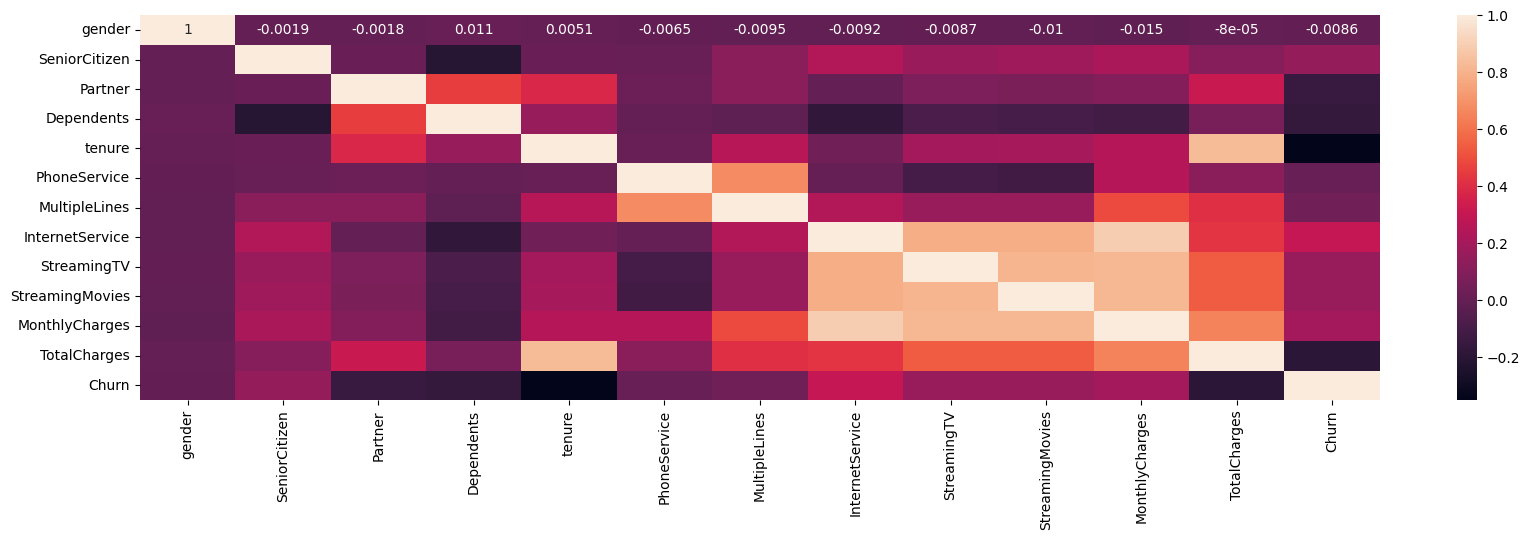

In [55]:
plt.figure(figsize = (20,5))
sns.heatmap(df.corr(),annot = True);

It is a huge matrix with too many features. We will check the correlation only with respect to Churn.

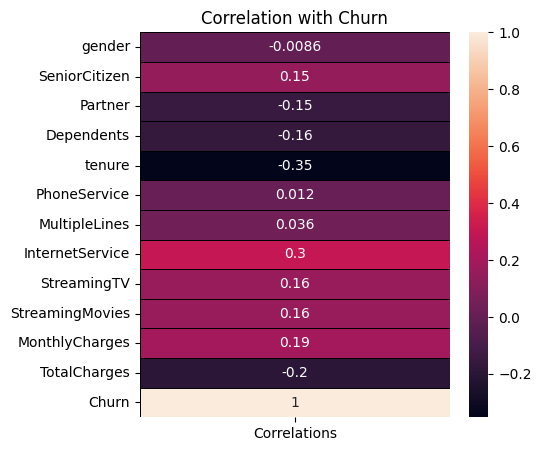

In [56]:
df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce')

numeric_df = df.select_dtypes(include=[np.number]).dropna()
numeric_df = numeric_df.astype('float64')

# correlations with 'Churn'
try:
    corr = numeric_df.corrwith(numeric_df['Churn']).to_frame()
    corr.columns = ['Correlations']

    plt.figure(figsize=(5, 5))
    sns.heatmap(corr, annot=True, linewidths=0.4, linecolor='black')
    plt.title('Correlation with Churn')
    plt.show()
except Exception as e:
    print("Error calculating correlations:", e)

- MulipleLines, PhoneService, gender, StreamingTV, StreamingMovies and InternetService does not display any kind of correlation. We drop the features with correlation coefficient between (-0.1,0.1).
- Remaining features either display a significant positive or negative correlation.

### Feature Selection for Categorical Features :

### Chi-Squared Test :

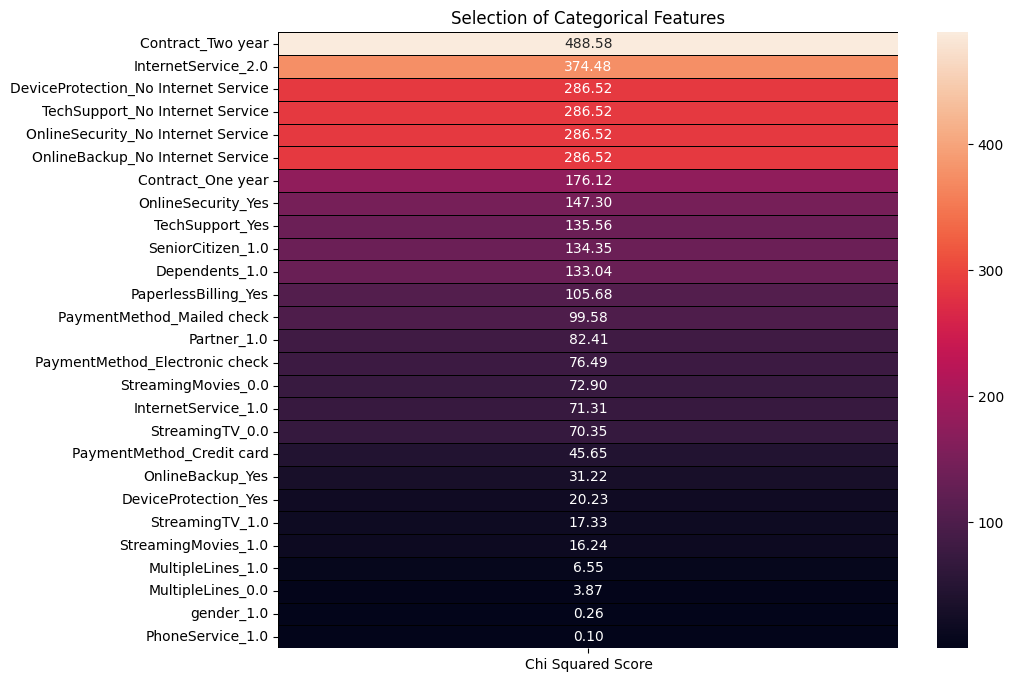

In [57]:
target = df['Churn']

categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]
features = df[categorical_features]

encoder = OneHotEncoder(drop='first', sparse_output=False)  
encoded_features = encoder.fit_transform(features)

encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(features.columns))

# SelectKBest with chi2 for feature selection
best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(encoded_features_df, target)

feature_scores = pd.DataFrame(data=fit.scores_, index=encoded_features_df.columns, columns=['Chi Squared Score'])

plt.figure(figsize=(10, 8))
sns.heatmap(feature_scores.sort_values(by='Chi Squared Score', ascending=False), annot=True, linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Categorical Features')
plt.show()

PhoneService, gender, StreamingTV, StreamingMovies, MultipleLines and InternetService display a very low relation with Churn.

### Feature Selection for Numerical Features :

### ANOVA Test :

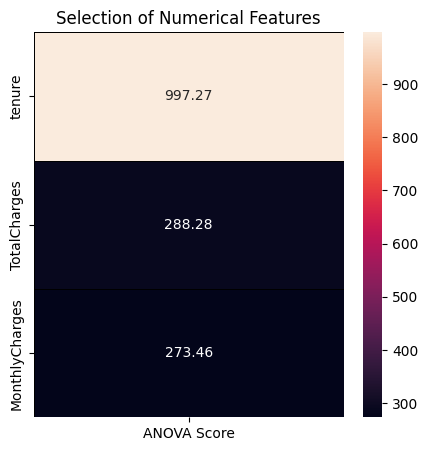

In [58]:
features = df.loc[:,numerical_features]
target = df.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

According to the ANOVA test, higher the value of the ANOVA score, higher the importance of the feature.
From the above results, we need to include all the numerical features for modeling.

# Modeling

In [59]:
df2.drop(columns = ['PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService'],inplace = True)

In [60]:
# Check data types 
df2 = df2.convert_dtypes() 
df2 = df2.dropna()  

In [61]:
df_majority = df2[df2['Churn'] == 0]
df_minority = df2[df2['Churn'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples=len(df_majority),  
                                 random_state=42) 

# combine majority and upsampled minority
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print("Balanced data distribution:\n", df_balanced['Churn'].value_counts())

Balanced data distribution:
 1    5174
0    5174
Name: Churn, dtype: Int64


In [62]:
# the majority and minority classes
majority_class = df2[df2['Churn'] == 0]
minority_class = df2[df2['Churn'] == 1]

# we will upsample the minority class to match the majority count as an example

minority_upsampled = resample(minority_class,
                              replace=True,      
                              n_samples=len(majority_class),  
                              random_state=42)   

# combine 
df_balanced = pd.concat([majority_class, minority_upsampled])

# define f1 and t1 based on the balanced dataset
f1 = df_balanced.iloc[:, :13].values
t1 = df_balanced.iloc[:, 13].values

In [63]:
features = df2.drop(columns=['customerID','Churn'])  

features = pd.get_dummies(features, drop_first=True)  

target = df2['Churn'].astype(int)

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=2)

In [64]:
def model(classifier, x_train, y_train, x_test, y_test):

    classifier.fit(x_train, y_train)
    
    prediction = classifier.predict(x_test)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    print("Cross Validation Score:", '{0:.2%}'.format(cross_val_score(classifier, x_train, y_train, cv=cv, scoring='roc_auc').mean()))
    
    print("ROC AUC Score:", '{0:.2%}'.format(roc_auc_score(y_test, prediction)))

def model_evaluation(classifier, x_test, y_test):
    cm = confusion_matrix(y_test, classifier.predict(x_test))
    print("Confusion Matrix:\n", cm)  
    
    #Confusion matrix wasnt displaying the True Neg and False Pos
    #plt.figure(figsize=(6, 4))
    #sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
    #plt.xlabel("Predicted Labels")
    #plt.ylabel("True Labels")
    #plt.title("Confusion Matrix")
    #plt.show()
    
    # Print Classification Report
    print("\nClassification Report:\n", classification_report(y_test, classifier.predict(x_test)))

In [65]:
classifier_xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000, scale_pos_weight=(len(t1[t1 == 0]) / len(t1[t1 == 1])))

In [66]:
model(classifier_xgb,x_train,y_train,x_test,y_test)

Cross Validation Score: 84.64%
ROC AUC Score: 73.98%


In [67]:
model_evaluation(classifier_xgb,x_test,y_test)

Confusion Matrix:
 [[707 354]
 [ 65 283]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.77      1061
           1       0.44      0.81      0.57       348

    accuracy                           0.70      1409
   macro avg       0.68      0.74      0.67      1409
weighted avg       0.80      0.70      0.72      1409



In [68]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)

In [69]:
model(classifier_rf,x_train,y_train,x_test,y_test)

Cross Validation Score: 83.62%
ROC AUC Score: 66.72%


In [70]:
model_evaluation(classifier_rf,x_test,y_test)

Confusion Matrix:
 [[992  69]
 [209 139]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      1061
           1       0.67      0.40      0.50       348

    accuracy                           0.80      1409
   macro avg       0.75      0.67      0.69      1409
weighted avg       0.79      0.80      0.78      1409



In [71]:
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)

In [72]:
model(classifier_dt,x_train,y_train,x_test,y_test)

Cross Validation Score: 81.98%
ROC AUC Score: 69.47%


In [73]:
model_evaluation(classifier_dt,x_test,y_test)

Confusion Matrix:
 [[968  93]
 [182 166]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88      1061
           1       0.64      0.48      0.55       348

    accuracy                           0.80      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



# Measures for Reducing Customer Churn & Revenue Increase

- 3 types of customers should be targeted : SeniorCitizen, Living with a Partner, living alone

- The number of SeniorCitizen customers are low but their lowerlimit of MonthlyCharges is higher than the other customers. Thus, SeniorCitizen customers are ready to pay top dollar but they need to catered with that level of service. For customers with a Partner as well as customers living alone, they prefer services with MonthlyCharges below 65.

- Inorder to create a strong foundation of customers, Telco Company needs to create an easy and affordable entry point for their services. For the tenure of 1st 6 months, it needs to focus extensively on OnlineSecurity, OnlineBackup, DeviceProtection & TechSupport as this period is the most critical and uncertain for the customers. They must lower the churn tenure of 40 - 50 months for these services

- Once they build a solid pipeline of support services for customers, they need to push the usage of MultipleLines & Fiber Optic cables for the PhoneService & InternetService respectively. But the major hurdle for these 2 services is the starting point of 75+ in MonthlyCharges.

- Thus, they need to create combinations of options provided for PhoneService & InternetService where average of these MonthlyCharges will be in the range of 100 - 120 :
  -  No MultipleLines + OpticFiber
  -  MultipleLines + DSL

- This will increase the mean income from a user as it completely drops the option of choosing a combination of No MultipleLines + DSL whose mean MonthlyCharges is probably 60 - 70
- StreamingTV and StreamingMovies need to be made affordable as well as reducing it's churn tenure. The content of these services should be targeting all types of customers. This needs to followed up with an easy and hassle free PaymentMethod.
- It needs to put an end to the Electronic check for payment purposes due to it's high churn and focus entirely on Bank Transfer (automatic) & Credit Card (automatic)! However, they will be challenged to reduce the median churn tenure of above 20 months for these 2 PaymentMethod which is double the churn tenure of Electronic check.
- Lower limit of Electronic check is around 60 whereas that of Bank Transfer (automatic) & Credit Card (automatic) is around 20 in MonthlyCharges. PaperlessBilling is another expensive feature with a starting point of 60 whereas the other options are cheap starting at 20 in MonthlyCharges.
- Once the MonthlyCharges for any single service hits the 70 mark, customers become very conscious about their MonthlyCharges. 